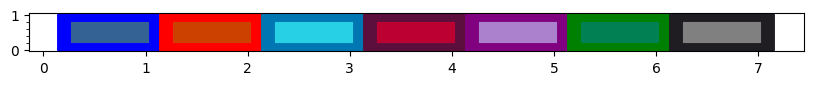

In [1]:
import json

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as ptchs
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.optimize
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from pandas.core.base import PandasObject
from sklearn.linear_model import Ridge

global_save = True
cpu_system = "das6"
cpu_vd_input_folder = f"{cpu_system}-cpu/"
cpu_mb_input_folder = f"../microbenchmarks/{cpu_system}/"
cpu_output_folder = f"../../images/{cpu_system}"

%run ../notebook_setup.ipynb

# Benchmarks
Plot benchmark results from running histond_benchmark.C with timers within TH1

## No Bulk API

### Fixed Bins

In [2]:
filename = "nonbulk_1d_fixedbins.csv"
hyp_df_bm = pd.read_csv(filename)
hyp_df_bm["nvals"] = hyp_df_bm["input"].apply(
    lambda s: float(s.split("_")[-1].split(".")[0])
)
hyp_df_bm["distribution"] = hyp_df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(hyp_df_bm, "tfindbin", np.float64)
convert_to_type(hyp_df_bm, "tfill", np.float64)
convert_to_type(hyp_df_bm, "tstats", np.float64)
del hyp_df_bm["input"]
hyp_df_bm.head(7)

,iter,env,nbins,bulksize,tfindbin,tfill,tstats,nvals,distribution
0,0,CPU,1,1,1.937491,1.620788,1.555348,1.000000e+08,uniform
1,0,CPU,1,1,9.478474,7.850704,7.620397,5.000000e+08,uniform
2,0,CPU,1,1,19.088344,15.712114,15.305721,1.000000e+09,uniform
3,0,CPU,1,1,94.319963,87.005841,75.569822,5.000000e+09,uniform
4,0,CPU,2,1,1.883125,1.552552,1.507859,1.000000e+08,uniform
5,0,CPU,2,1,9.347063,7.682685,7.485839,5.000000e+08,uniform
6,0,CPU,2,1,18.750533,15.447757,15.021956,1.000000e+09,uniform


In [3]:
gp_bm = hyp_df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize"])
gp_bm.mean()

iter   tfindbin      tfill  \
env distribution nvals        nbins bulksize                               
CPU uniform      1.000000e+08 1     1          1.0   1.875294   1.551172   
                              2     1          1.0   1.862105   1.540116   
                              5     1          1.0   1.876629   1.579942   
                              10    1          1.0   1.867486   1.538372   
                              20    1          1.0   1.861202   1.534309   
                              50    1          1.0   1.826746   1.556542   
                              100   1          1.0   1.822405   1.498089   
                              500   1          1.0   1.827565   1.562940   
                              1000  1          1.0   1.850249   1.542947   
                 5.000000e+08 1     1          1.0   9.333347   7.917787   
                              2     1          1.0   9.248723   7.584963   
                              5     1          1.0   9.256350   7.631018   
                              10    1          1.0   9.256568   7.609552   
                              20    1          1.0   9.342807   7.892647   
                              50    1          1.0   9.261069   8.100508   
                              100   1          1.0   9.203016   7.481004   
                              500   1          1.0   9.147344   7.538352   
                              1000  1          1.0   9.227314   8.092365   
                 1.000000e+09 1     1          1.0  18.951855  15.468729   
                              2     1          1.0  18.545456  15.268573   
                              5     1          1.0  18.611900  15.309308   
                              10    1          1.0  18.657480  15.357767   
                              20    1          1.0  18.797937  15.647771   
                              50    1          1.0  18.441803  16.397713   
                              100   1          1.0  18.210651  15.044283   
                              500   1          1.0  18.319942  15.118158   
                              1000  1          1.0  18.474962  15.552236   
                 5.000000e+09 1     1          1.0  92.750470  86.291794   
                              2     1          1.0  92.807932  79.815401   
                              5     1          1.0  93.170286  77.519193   
                              10    1          1.0  95.189293  76.317781   
                              20    1          1.0  92.653465  76.921896   
                              50    1          1.0  91.370868  75.648633   
                              100   1          1.0  91.926550  77.635879   
                              500   1          1.0  91.307255  75.821473   
                              1000  1          1.0  91.581583  77.306689   

                                                 tstats  
env distribution nvals        nbins bulksize             
CPU uniform      1.000000e+08 1     1          1.503002  
                              2     1          1.492257  
                              5     1          1.496295  
                              10    1          1.496536  
                              20    1          1.490506  
                              50    1          1.463339  
                              100   1          1.458444  
                              500   1          1.464790  
                              1000  1          1.513280  
                 5.000000e+08 1     1          7.487946  
                              2     1          7.378729  
                              5     1          7.412561  
                              10    1          7.409907  
                              20    1          7.414596  
                              50    1          7.324639  
                              100   1          7.267518  
                              500   1          7.319509  
                              1000  1          7.520136

In [4]:
unique_nbins = hyp_df_bm["nbins"].unique().astype(np.float64)
unique_nvals = hyp_df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = hyp_df_bm["bulksize"].unique().astype(np.float64)
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize

(array([   1.,    2.,    5.,   10.,   20.,   50.,  100.,  500., 1000.]),
 array([1.e+08, 5.e+08, 1.e+09, 5.e+09]),
 array([1.]))

Plots the total time spent on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **different** number of **doubles**. Total time averaged over **3 runs**

In [5]:
selected_env = "CPU"
selected_bulksize = 1
selected_bins = unique_nbins
selected_nvals = 500000000
selected_distr = "uniform"
selected_edges = True

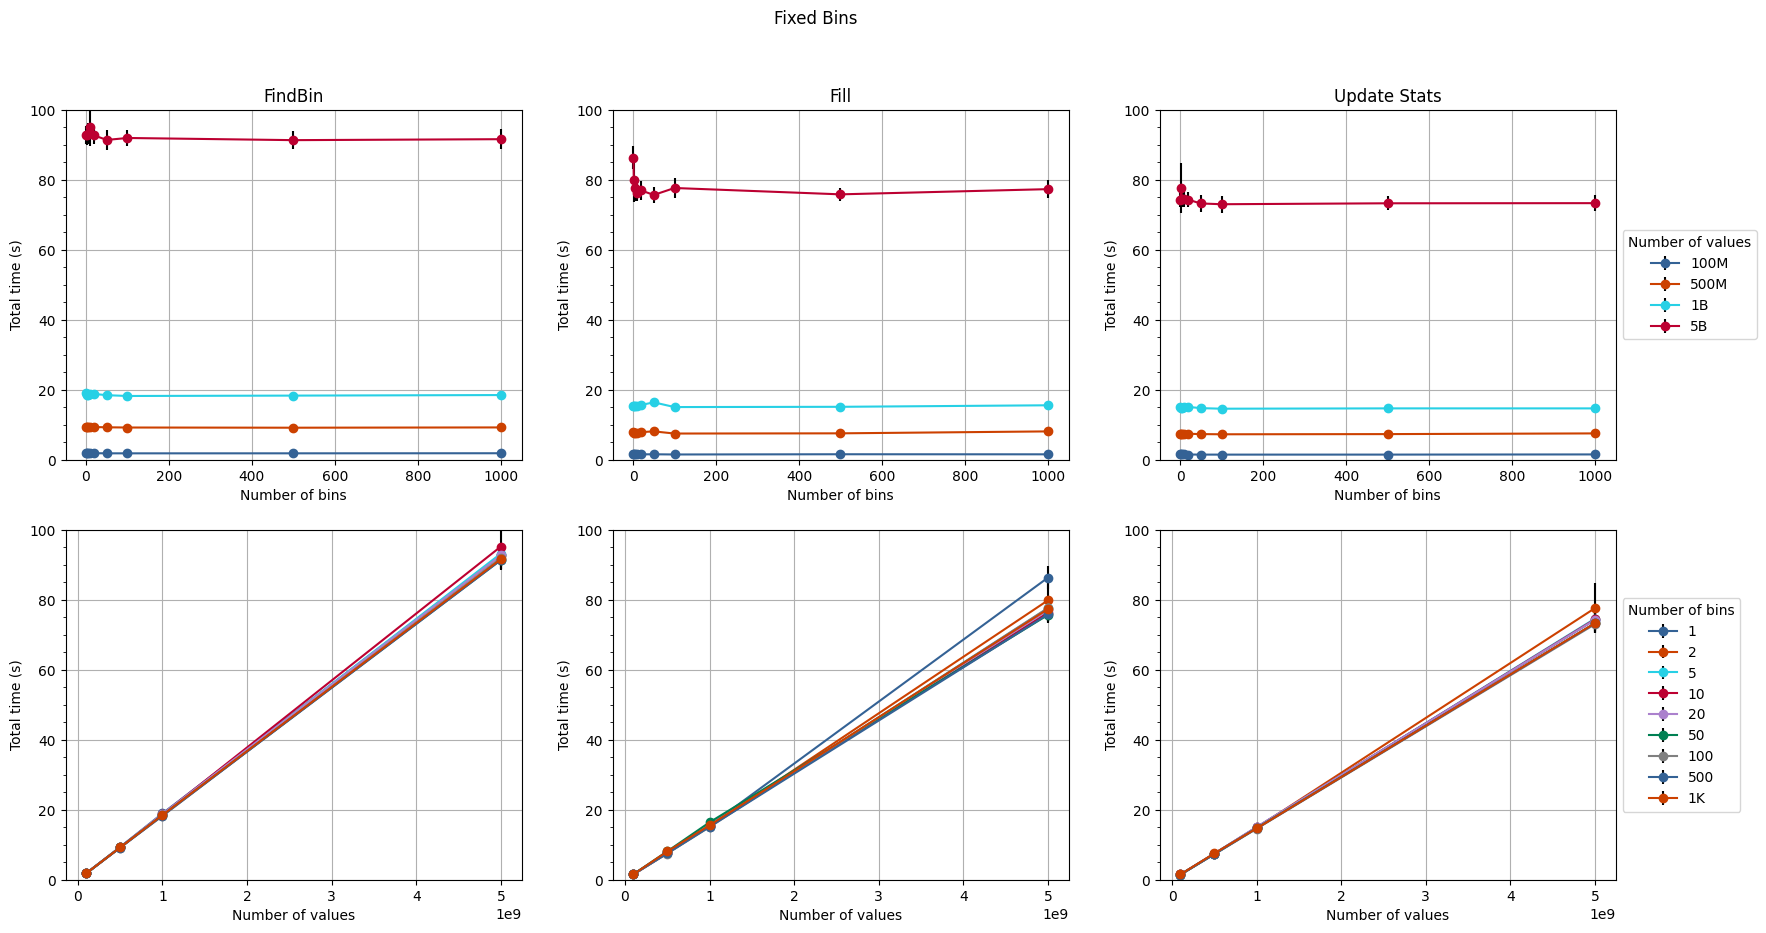

In [6]:
plt.figure(figsize=(20, 10))
plt.suptitle("Fixed Bins")


def plot_perval(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nv in unique_nvals:
        plt.errorbar(
            unique_nbins,
            gp_bm.mean().loc[selected_env, selected_distr, nv, :, selected_bulksize][
                col
            ],
            yerr=gp_bm.std().loc[
                selected_env, selected_distr, nv, :, selected_bulksize
            ][col],
            marker="o",
            ecolor="k",
            label=f"{human_readable(nv)}",
        )
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.ylabel(ylabel)


def plot_perbin(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(
            unique_nvals,
            gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize][
                col
            ],
            yerr=gp_bm.std().loc[
                selected_env, selected_distr, :, nb, selected_bulksize
            ][col],
            marker="o",
            ecolor="k",
            label=f"{human_readable(nb)}",
        )
    plt.xlabel("Number of values")
    plt.ylim(ylim)
    plt.ylabel(ylabel)


ylim = [0, 100]
plt.subplot(231)
plot_perval("FindBin", "tfindbin", "Number of bins", "Total time (s)", ylim)

plt.subplot(232)
plot_perval("Fill", "tfill", "Number of bins", "Total time (s)", ylim)

plt.subplot(233)
plot_perval("Update Stats", "tstats", "Number of bins", "Total time (s)", ylim)
plt.legend(title="Number of values", loc="center left", bbox_to_anchor=(1, 0.5))

ylim = [0, 100]
plt.subplot(234)
plot_perbin("", "tfindbin", "Number of values", "Total time (s)", ylim)

plt.subplot(235)
plot_perbin("", "tfill", "Number of values", "Total time (s)", ylim)

plt.subplot(236)
plot_perbin("", "tstats", "Number of values", "Total time (s)", ylim)
plt.legend(title="Number of bins", loc="center left", bbox_to_anchor=(1, 0.5))

Plots the *average* time spent *per value* on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **different** number of **doubles**. Total time averaged over **3 runs**

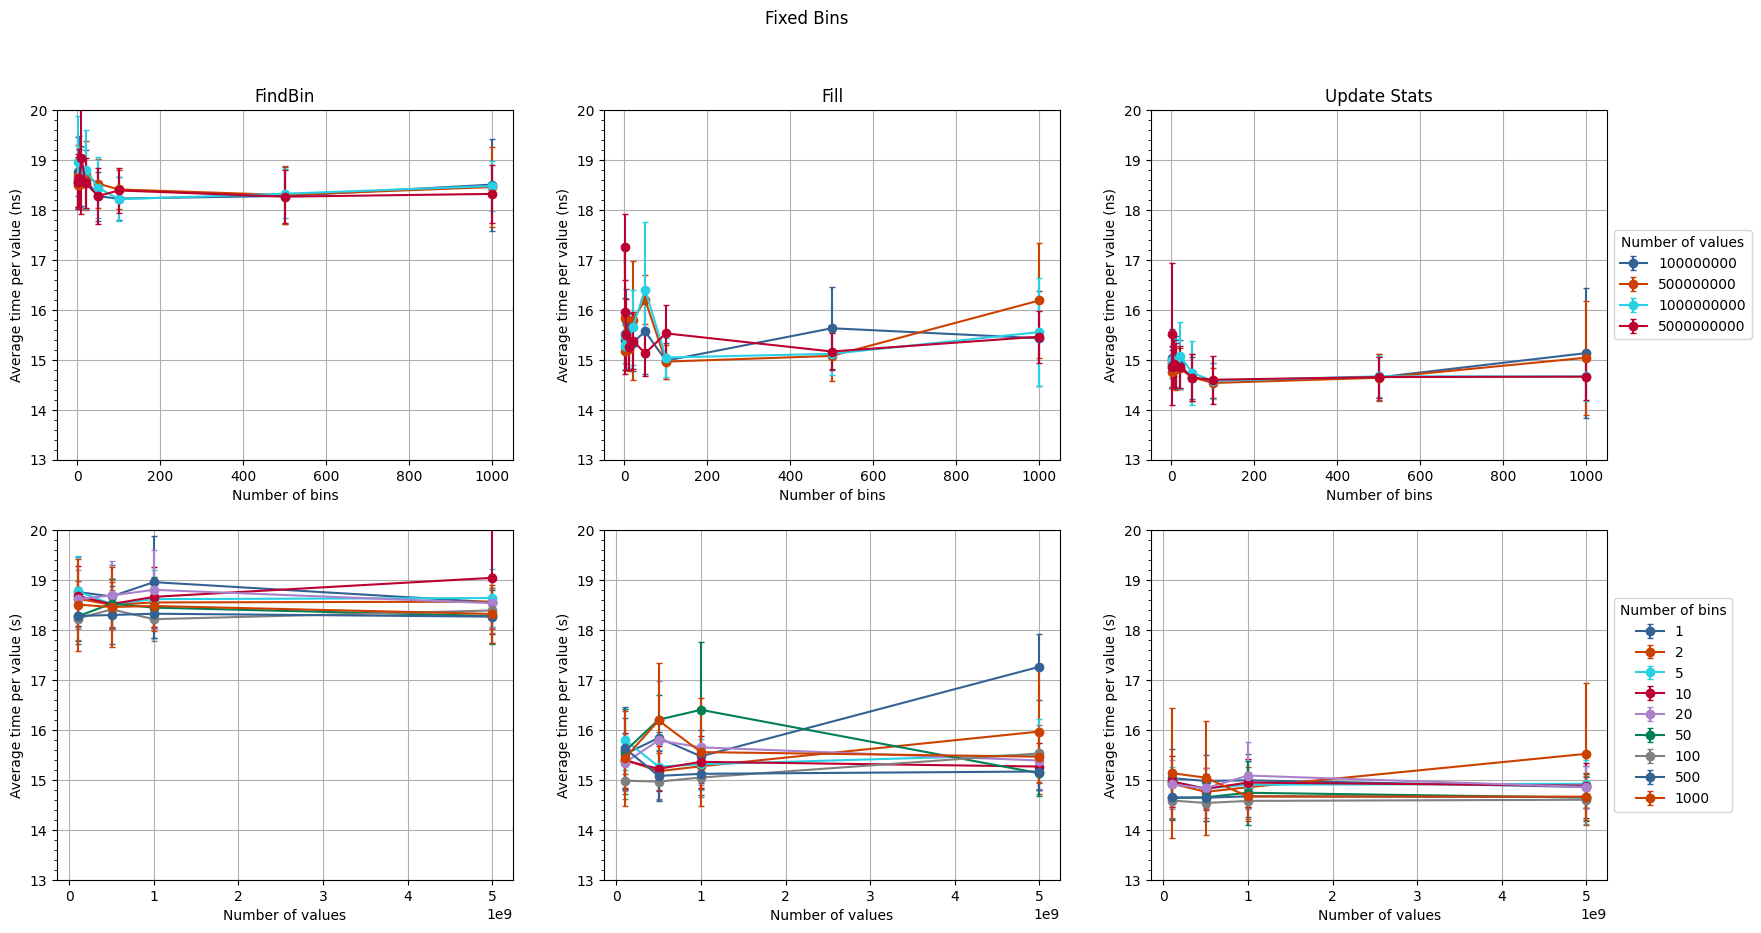

In [7]:
plt.figure(figsize=(20, 10))
plt.suptitle("Fixed Bins")


def plot_perval_normalized(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nv in unique_nvals:
        plt.errorbar(
            unique_nbins,
            gp_bm.mean().loc[selected_env, selected_distr, nv, :, selected_bulksize][
                col
            ]
            / nv
            / norm,
            yerr=gp_bm.std().loc[selected_env, selected_distr, nv, :, 1][col]
            / nv
            / norm,
            marker="o",
            capsize=2,
            label=f"{int(nv)}",
        )
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.ylabel(ylabel)


def plot_perbin_normalized(title, col, xlabel, ylabel, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(
            unique_nvals,
            gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize][
                col
            ]
            / unique_nvals
            / norm,
            yerr=gp_bm.std().loc[
                selected_env, selected_distr, :, nb, selected_bulksize
            ][col]
            / unique_nvals
            / norm,
            marker="o",
            capsize=2,
            label=f"{int(nb)}",
        )
    plt.xlabel("Number of values")
    plt.ylim(ylim)
    plt.ylabel("Average time per value (s)")


norm = 1e-9
ylim = [13, 20]
plt.subplot(231)
plot_perval_normalized(
    "FindBin", "tfindbin", "Number of bins", "Average time per value (ns)", ylim, norm
)

plt.subplot(232)
plot_perval_normalized(
    "Fill", "tfill", "Number of bins", "Average time per value (ns)", ylim, norm
)

plt.subplot(233)
plot_perval_normalized(
    "Update Stats",
    "tstats",
    "Number of bins",
    "Average time per value (ns)",
    ylim,
    norm,
)
plt.legend(title="Number of values", loc="center left", bbox_to_anchor=(1, 0.5))

ylim = [13, 20]
plt.subplot(234)
plot_perbin_normalized(
    "", "tfindbin", "Number of values", "Average time per value (ns)", ylim, norm
)

plt.subplot(235)
plot_perbin_normalized(
    "", "tfill", "Number of values", "Average time per value (ns)", ylim, norm
)

plt.subplot(236)
plot_perbin_normalized(
    "", "tstats", "Number of values", "Average time per value (ns)", ylim, norm
)
plt.legend(title="Number of bins", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

#### root plot

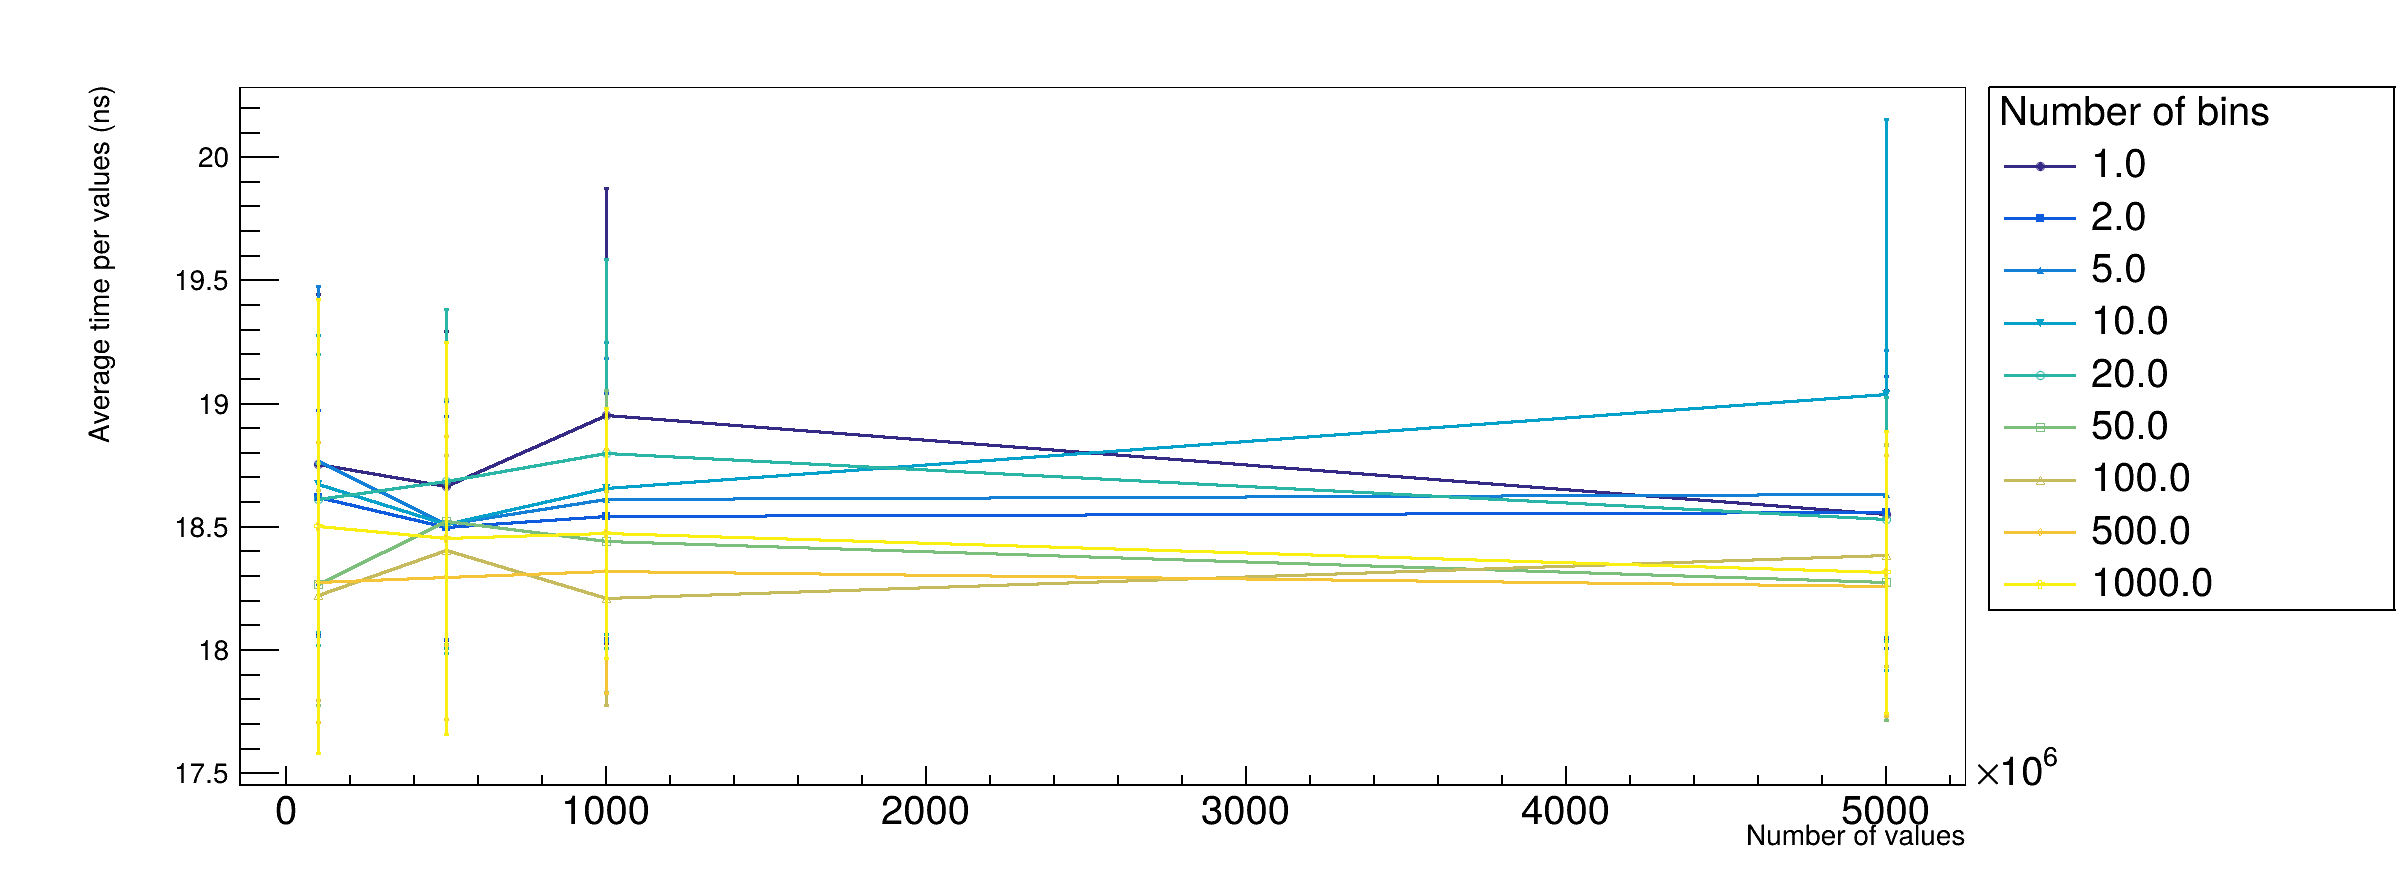

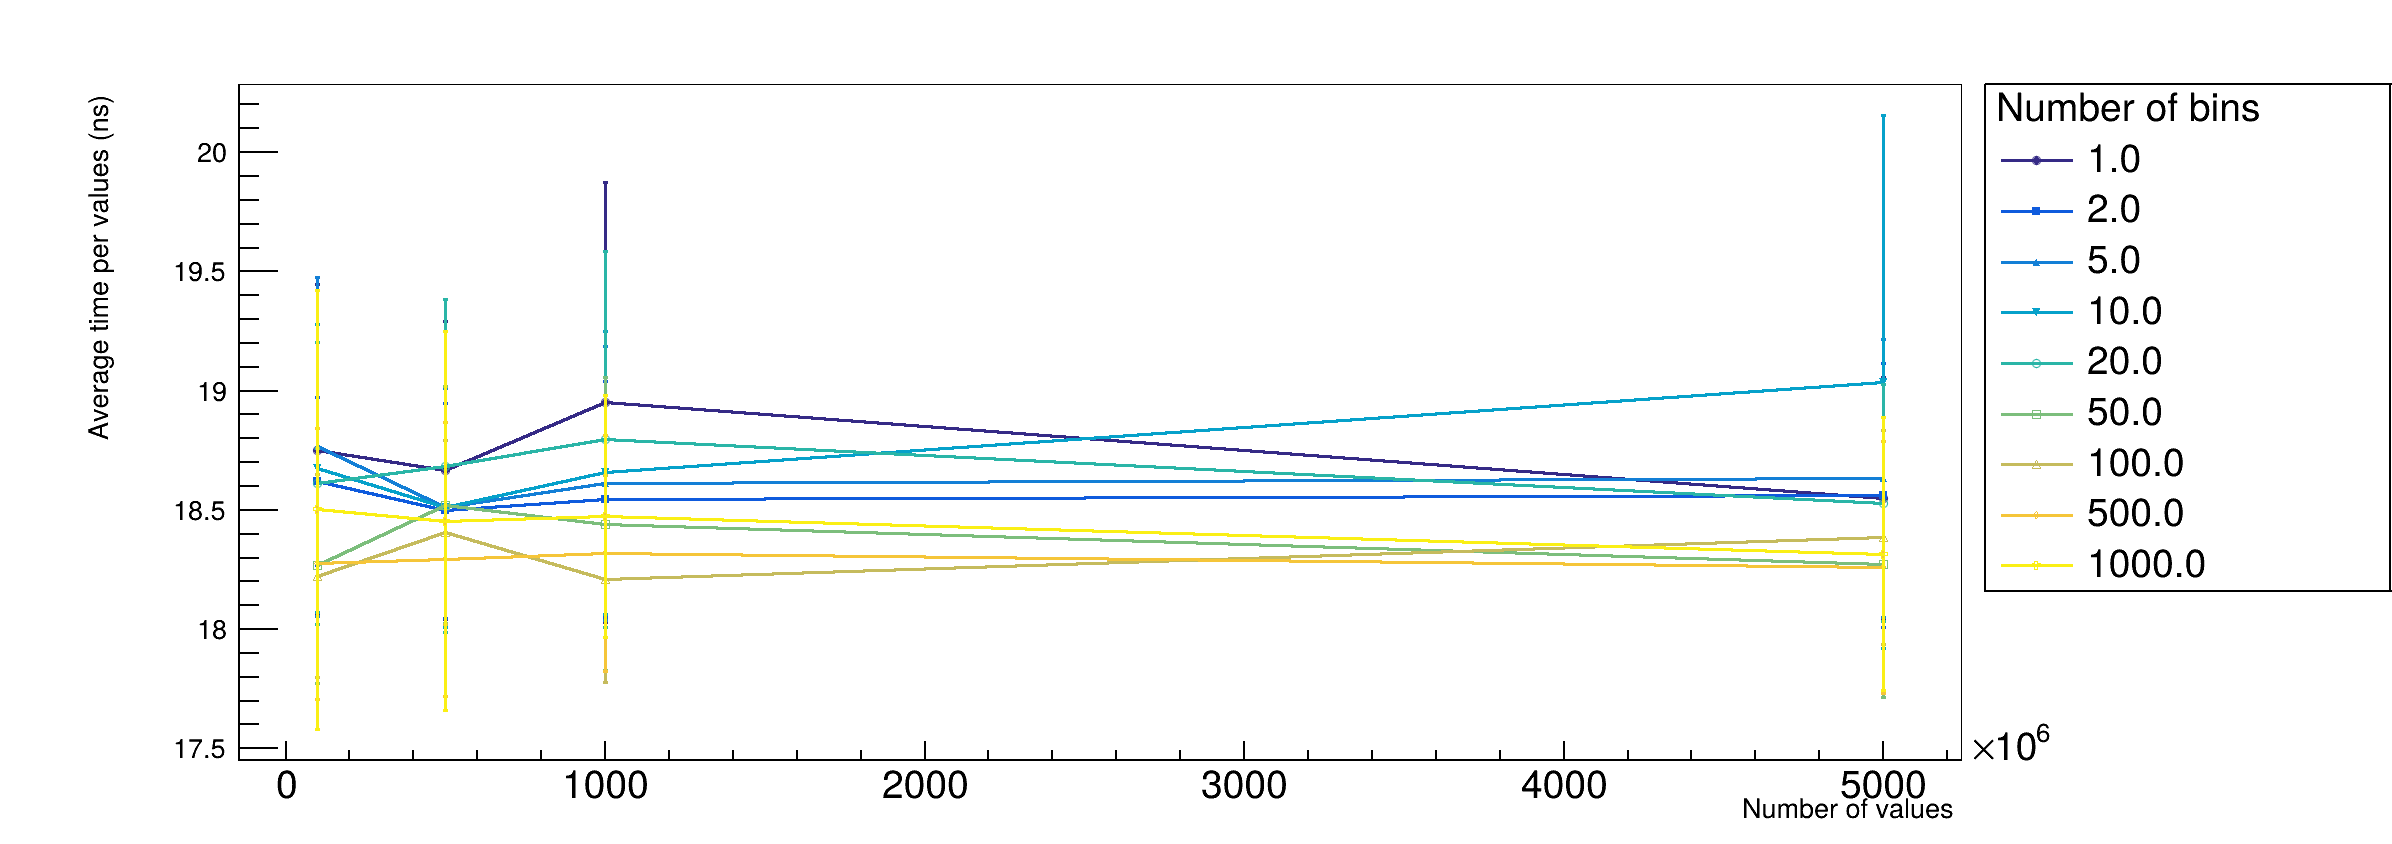

In [8]:
%jsroot off

selected_env = "CPU"
selected_bulksize = 1
selected_bins = unique_nbins
selected_nvals = 500000000
selected_distr = "uniform"
selected_edges = True

c = ROOT.TCanvas("c1", "")
rmargin = 0.18
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.3, 1, 0.9)
l.SetHeader("Number of bins")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_bins):
    g = ROOT.TGraphErrors(len(unique_nvals), unique_nvals, 
                          gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize]
                                          ["tfindbin"].values/unique_nvals/norm,
                          ROOT.kNone,
                          gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize]
                                          ["tfindbin"].values/unique_nvals/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
c.SaveAs("findbin_benchmark.pdf")# fmt: skip
c.DrawClone()

### Variable Bins

In [9]:
filename = "nonbulk_1d_varbins.csv"
hyp_df_bm = pd.read_csv(filename)
hyp_df_bm["nvals"] = hyp_df_bm["input"].apply(
    lambda s: float(s.split("_")[-1].split(".")[0])
)
hyp_df_bm["distribution"] = hyp_df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(hyp_df_bm, "tfindbin", np.float64)
convert_to_type(hyp_df_bm, "tfill", np.float64)
convert_to_type(hyp_df_bm, "tstats", np.float64)
del hyp_df_bm["input"]
hyp_df_bm.head(7)

,iter,env,nbins,bulksize,tfindbin,tfill,tstats,nvals,distribution
0,0,CPU,1,1,8.505813,7.377600,7.210849,500000000.0,uniform
1,0,CPU,2,1,10.373811,7.340820,7.208909,500000000.0,uniform
2,0,CPU,5,1,12.226278,7.348425,7.215204,500000000.0,uniform
3,0,CPU,10,1,13.837383,7.321588,7.191632,500000000.0,uniform
4,0,CPU,20,1,15.398913,7.350384,7.185699,500000000.0,uniform
5,0,CPU,50,1,17.970907,7.431197,7.193031,500000000.0,uniform
6,0,CPU,100,1,19.601212,7.319499,7.188359,500000000.0,uniform


In [10]:
gp_bm = hyp_df_bm.groupby(["env", "distribution", "nvals", "nbins", "bulksize"])
gp_bm.mean()

iter   tfindbin     tfill  \
env distribution nvals       nbins bulksize                              
CPU uniform      500000000.0 1     1          1.0   8.486525  7.361389   
                             2     1          1.0  10.338577  7.629487   
                             5     1          1.0  12.239609  7.333011   
                             10    1          1.0  13.823583  7.317982   
                             20    1          1.0  15.489936  7.324246   
                             50    1          1.0  18.713807  7.593892   
                             100   1          1.0  19.838589  7.320013   
                             500   1          1.0  24.023485  7.404909   
                             1000  1          1.0  26.373816  7.720180   

                                               tstats  
env distribution nvals       nbins bulksize            
CPU uniform      500000000.0 1     1         7.196308  
                             2     1         7.200462  
                             5     1         7.201386  
                             10    1         7.189661  
                             20    1         7.184463  
                             50    1         7.301179  
                             100   1         7.184397  
                             500   1         7.198944  
                             1000  1         7.264606

In [ ]:
unique_nbins = hyp_df_bm["nbins"].unique().astype(np.float64)
unique_nvals = hyp_df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = hyp_df_bm["bulksize"].unique().astype(np.float64)
unique_nbins, unique_nvals, unique_bulksize

(array([   1.,    2.,    5.,   10.,   20.,   50.,  100.,  500., 1000.]),
 array([5.e+08]),
 array([1.]))

Plots the *average* time spent *per value* on finding bins, filling bins, and updating stats for **1D** histograms with **fixed bins**, **different** number of bins and **0.5B** number of **doubles**. Total time averaged over **3 runs**

In [ ]:
plt.figure(figsize=(20, 5))
plt.suptitle("Variable Bins")

norm = 1
ylim = [0 * 1e-8, 5.5 * 1e-8]
plt.subplot(131)
plot_perval_normalized(
    "FindBin", "tfindbin", "Number of bins", "Average time per value (ns)", ylim, norm
)

plt.subplot(132)
plot_perval_normalized(
    "Fill", "tfill", "Number of bins", "Average time per value (ns)", ylim, norm
)

plt.subplot(133)
plot_perval_normalized(
    "Update Stats",
    "tstats",
    "Number of bins",
    "Average time per value (ns)",
    ylim,
    norm,
)
plt.legend(title="Number of values", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
def convert_to_double_list(hyp_df, col):
    hyp_df[col] = hyp_df[col].apply(lambda s: [np.float64(x) for x in s.split()])


filename = "nonbulk_1d_pervarbin.csv"
hyp_df_bm = pd.read_csv(filename)
hyp_df_bm["nvals"] = hyp_df_bm["input"].apply(
    lambda s: float(s.split("_")[-1].split(".")[0])
)
hyp_df_bm["distribution"] = hyp_df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_double_list(hyp_df_bm, "tfindbin")
convert_to_double_list(hyp_df_bm, "tfill")
convert_to_type(hyp_df_bm, "tstats", np.float64)
del hyp_df_bm["input"]
hyp_df_bm.head(7)

Plots the *average* time spent on finding a specific bin in an array with **100** bins for **0.5B** number of **doubles**. Total time averaged over **3 runs**

In [ ]:
# w = 2400
# h = 900
# c = ROOT.TCanvas("c1", title, w, h)
# c.SetRightMargin(0.32)
# c.SetBottomMargin(0.33)
# c.Divide(2,1)

# l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
# l.SetTextSize(0.05)

# g = ROOT.TGraph(100, np.arange(100, dtype=np.float64), gp_bm.agg(mean_list).loc["CPU", "uniform", 500000000, 100, 1]["tfindbin"][1:-1])
# g.SetMarkerSize(1)
# g.SetMarkerStyle(8)
# l.AddEntry(g, "Microbenchmark", "p")
# xaxis = g.GetXaxis()
# xaxis.SetTitle("Bin")
# yaxis = g.GetYaxis()
# yaxis.SetTitle(f"Time (ns)")
# xaxis.SetRangeUser(0, 100)

# c.cd(1)
# g.Draw("ALP")

# title="Time to find bin in an array with 100 bins"
# g.SetTitle(title)

# l.Draw()
# c.Draw()

Investigate caching within Histogram Filling

## With Bulk API

### Fixed Bins

In [ ]:
filename = "das6-cpu/20231219-223056"
hyp_df_bm = pd.read_csv(filename)
hyp_df_bm["nvals"] = hyp_df_bm["input"].apply(
    lambda s: float(s.split("_")[-1].split(".")[0])
)
hyp_df_bm["distribution"] = hyp_df_bm["input"].apply(lambda s: s.split("_")[1])
convert_to_type(hyp_df_bm, "tfindbin", np.float64)
convert_to_type(hyp_df_bm, "tfill", np.float64)
convert_to_type(hyp_df_bm, "tstats", np.float64)
convert_to_type(hyp_df_bm, "edges", np.bool_)
del hyp_df_bm["input"]
hyp_df_bm.head(7)

In [ ]:
gp_bm = hyp_df_bm.groupby(
    ["env", "distribution", "nvals", "nbins", "bulksize", "edges"]
)
gp_bm.mean()

In [ ]:
unique_nbins = hyp_df_bm["nbins"].unique().astype(np.float64)
unique_nvals = hyp_df_bm["nvals"].unique().astype(np.float64)
unique_bulksize = hyp_df_bm["bulksize"].unique().astype(np.float64)
unique_distribution = hyp_df_bm["distribution"].unique()
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize

In [ ]:
selected_env = "CPU"
selected_bulksize = 32768
selected_bins = unique_nbins[:-1]
selected_nvals = 500000000
selected_distr = "constant-0"
selected_edges = True


def plot_perbulk_normalized(title, col, xlabel, ylabel, xlim, ylim, norm=1):
    plt.title(title)
    for bs in unique_bulksize:
        plt.errorbar(
            unique_nbins,
            gp_bm.mean().loc[
                selected_env, selected_distr, selected_nvals, :, bs, selected_edges
            ][col]
            / norm,
            yerr=gp_bm.std().loc[
                selected_env, selected_distr, selected_nvals, :, bs, selected_edges
            ][col]
            / norm,
            marker="o",
            capsize=3,
            label=f"{int(bs)}",
        )
    plt.xlabel(xlabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel(ylabel)


def plot_perbin_normalized(title, col, xlabel, ylabel, xlim, ylim, norm=1):
    plt.title(title)
    for nb in unique_nbins:
        plt.errorbar(
            unique_bulksize,
            gp_bm.mean().loc[
                selected_env, selected_distr, selected_nvals, nb, :, selected_edges
            ][col]
            / norm,
            yerr=gp_bm.std().loc[
                selected_env, selected_distr, selected_nvals, nb, :, selected_edges
            ][col]
            / norm,
            marker="o",
            capsize=3,
            label=f"{int(nb)}",
        )
    plt.xlabel(xlabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.ylabel(ylabel)


plt.figure(figsize=(20, 10))
plt.suptitle("Fixed Bins with Bulk API")

norm = selected_nvals * 1e-9
xlim = []
ylim = []
plt.subplot(231)
plot_perbulk_normalized(
    "FindBin",
    "tfindbin",
    "Number of bins",
    "Average time per value (ns)",
    xlim,
    ylim,
    norm,
)

plt.subplot(232)
plot_perbulk_normalized(
    "Fill", "tfill", "Number of bins", "Average time per value (ns)", xlim, ylim, norm
)

plt.subplot(233)
plot_perbulk_normalized(
    "Update Stats",
    "tstats",
    "Number of bins",
    "Average time per value (ns)",
    xlim,
    ylim,
    norm,
)
plt.legend(title="Bulk size", loc="center left", bbox_to_anchor=(1, 0.5))

norm = 1e-9
xlim = []
ylim = []
plt.subplot(234)
plot_perbin_normalized(
    "", "tfindbin", "Bulk size", "Average time per value (ns)", xlim, ylim, norm
)

plt.subplot(235)
plot_perbin_normalized(
    "", "tfill", "Bulk size", "Average time per value (ns)", xlim, ylim, norm
)

plt.subplot(236)
plot_perbin_normalized(
    "", "tstats", "Bulk size", "Average time per value (ns)", xlim, ylim, norm
)
plt.legend(title="Number of bins", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

Plot average total time. **Note that this timing includes overhead of timers for the measurements above**

In [ ]:
plt.figure(figsize=(10, 5))
plt.suptitle("Fixed Bins")

norm = 1
xlim = []
ylim = []
plt.subplot(111)
plot_perbin_normalized(
    "Total runtime on CPU with bulk API",
    "ttotal",
    "Bulk Size",
    "Total runtime (s)",
    xlim,
    ylim,
    norm,
)
plt.legend(title="Number of bins", loc="center left", bbox_to_anchor=(1, 0.5))

**ROOT plot** Plot average time per value for different number of bins

In [ ]:
%jsroot off

selected_env = "CPU"
selected_bulksize = 32768
selected_bins = unique_nbins
selected_distr = "constant-0.5"
selected_edges = True
norm = unique_nvals/1e9

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.55, 1, 0.9)
l.SetHeader("Number of bins")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_bins):
    g = ROOT.TGraphErrors(len(unique_nvals), unique_nvals, 
                          gp_bm.mean().loc[selected_env, selected_distr, :, nb, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm,
                          ROOT.kNone,
                          gp_bm.std().loc[selected_env, selected_distr, :, nb, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, human_readable(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
c.SaveAs("../../images/findbin_nvals_vs_nbins.pdf")  # fmt: skip
c.DrawClone()

In [ ]:
%jsroot off

selected_env = "CPU"
selected_bulksize = 32768
selected_bins = []
selected_distr = "constant-0.5"
selected_edges = True
selected_nvals = 500e6
norm = selected_nvals*1e-9

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.55, 1, 0.9)
l.SetHeader("Input type")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for (nbi, dis), lbl in zip(enumerate(unique_distribution), ["Uniform", "Bin 0", "Middle bin"]):
    g = ROOT.TGraphErrors(len(unique_nbins), unique_nbins, 
                          gp_bm.mean().loc[selected_env, dis, selected_nvals, :, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm,
                          ROOT.kNone,
                          gp_bm.std().loc[selected_env, dis, selected_nvals, :, selected_bulksize, selected_edges]
                                          ["tfindbin"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(dis).title())
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# c.SetLogx()
0000
yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
c.SaveAs("../../images/findbin_nbins_vs_distr.pdf") # fmt: skip
c.DrawClone()

# Models

In [ ]:
def f1_1(nbulks, bulksize, dim):
    T_d = 0
    T_u = 0
    T_Rhyp_df = 0
    T_gb = 0
    T_mb = 0
    T_fb = 0
    T_usb = 0
    return (
        T_d
        + T_u
        + T_Rhyp_df
        + np.sum([T_gb + T_mb + T_fb + T_usb for _ in range(nbulks)])
    )

## Microbenchmark Data

In [ ]:
filename = f"{cpu_mb_input_folder}/investigational_benchmarks.json"
# filename = "../microbenchmarks/das6/gbenchmark_evaluation.json"
# filename = "../das6-cpu-microbenchmark.result"

with open(filename, "r") as f:
    jdata = json.load(f)
bm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time": float})

convert_to_type(bm_df, "real_time", np.float64)
bm_df["func_name"] = bm_df["name"].apply(lambda s: s.split("/")[0][3:])
# bm_df["time (s)"] = bm_df["real_time"] * bm_df["time_unit"].apply(convert_unit)
del bm_df["family_index"], bm_df["per_family_instance_index"]

bm_df

In [ ]:
filename = "../microbenchmarks/das6/cpu_calibration.json"
# filename = "../das6-cpu-microbenchmark.result"

with open(filename, "r") as f:
    jdata = json.load(f)
clb_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time": float})

convert_to_type(clb_df, "real_time", np.float64)
clb_df["func_name"] = clb_df["name"].apply(lambda s: s.split("/")[0][3:].split("_")[0])
# bm_df["time (s)"] = bm_df["real_time"] * bm_df["time_unit"].apply(convert_unit)
del clb_df["family_index"], clb_df["per_family_instance_index"]

# clb_df.head(10)
clb_df

## Validation Data

In [ ]:
# validation_results = "das6-cpu/20231127-223143"
inner_validation_results = "das6-cpu/inner_validation"
inner_validation_df = pd.read_csv(inner_validation_results)
inner_validation_df["nvals"] = inner_validation_df["input"].apply(
    lambda s: float(s.split("_")[-1].split(".")[0])
)
inner_validation_df["distribution"] = inner_validation_df["input"].apply(
    lambda s: s.split("_")[1]
)
convert_to_type(inner_validation_df, "tfindbin", np.float64)
convert_to_type(inner_validation_df, "tfill", np.float64)
convert_to_type(inner_validation_df, "tstats", np.float64)
convert_to_type(inner_validation_df, "edges", np.bool_)
del inner_validation_df["input"]
inner_validation_df

In [ ]:
validation_results = "das6-cpu/validation"
validation_df = pd.read_csv(validation_results)
validation_df["nvals"] = validation_df["input"].apply(
    lambda s: float(s.split("_")[-1].split(".")[0])
)
validation_df["distribution"] = validation_df["input"].apply(lambda s: s.split("_")[1])
convert_to_type(validation_df, "tfindbin", np.float64)
convert_to_type(validation_df, "tfill", np.float64)
convert_to_type(validation_df, "tstats", np.float64)
convert_to_type(validation_df, "edges", np.bool_)
del validation_df["input"]
validation_df

In [ ]:
gp_ivd = inner_validation_df.groupby(
    ["env", "distribution", "nvals", "nbins", "bulksize", "edges"]
)
gp_ivd.mean()

In [ ]:
gp_vd = validation_df.groupby(
    ["env", "distribution", "nvals", "nbins", "bulksize", "edges"]
)
gp_vd.mean()

In [ ]:
unique_nbins = validation_df["nbins"].unique().astype(np.float64)
unique_nvals = validation_df["nvals"].unique().astype(np.float64)
unique_bulksize = validation_df["bulksize"].unique().astype(np.float64)
unique_distribution = validation_df["distribution"].unique()
unique_edges = [True, False]
unique_nbins, unique_nvals, unique_bulksize, unique_distribution, unique_edges

## Update Stats Bulk

In [ ]:
usb_df = clb_df[clb_df["func_name"] == "UpdateStats"].copy()
n_param = len(usb_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        usb_df[f"param_{i}"] = usb_df["name"].apply(
            lambda s: s.split("/")[i + 1].split("_")[0]
        )
    else:
        usb_df[f"param_{i}"] = usb_df["name"].apply(lambda s: s.split("/")[i + 1])

usb_mean = usb_df.loc[usb_df["name"].str.contains("mean")]
usb_std = usb_df.loc[usb_df["name"].str.contains("stddev")]
# convert_to_type(
usb_mean

In [ ]:
T_updatestats = (
    usb_mean.loc[usb_mean["param_0"] == "1"]["real_time"]
    * unit_to_unit_factor(usb_mean["time_unit"].values[0], "ns")
    / usb_mean["repetitions"].values[0]
).values[0]
T_updatestats

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/cpu_updatestats_validation.pdf"  # fmt: skip

selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        selected_nvals,
        unique_nbins,
        selected_bulksize,
        selected_edges,
    )
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]

    p = ax.errorbar(
        unique_nbins,
        avg["tstats"],
        yerr=std["tstats"],
        **bm_style,
        # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
        label=f"{map_distr_name(distr)}".title(),
    )
    # Legend Labels
    # ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,
    #                              facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
print(distr)
pred = np.repeat(
    T_updatestats * selected_nvals * unit_to_unit_factor("ns", "s"), len(unique_nbins)
)
ax.errorbar(
    unique_nbins,
    pred,
    c=pred_color,
    marker="s",
    markerfacecolor="none",
    ls="--",
    markersize=7,
)
observ = avg["tstats"].values
print("MAE:", mae(pred, observ))
print("R2:", r2(pred, observ) * 100)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
plt.ylim([0, 50])
plt.ylabel("Average runtime (s)")

ax = plt.subplot(122)
for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        unique_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]

    p = ax.errorbar(
        unique_nvals,
        avg["tstats"],
        yerr=std["tstats"],
        marker="s",
        ecolor="k",
        markersize=5,
        # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
        label=f"{map_distr_name(distr)}".title(),
    )
    # Legend Labels
    # ax.add_patch(ptchs.Rectangle((0, 0), 0, 0,
    #                              facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"))
print(distr)
pred = T_updatestats * unique_nvals * unit_to_unit_factor("ns", "s")
ax.errorbar(
    unique_nvals,
    pred,
    c=pred_color,
    marker="s",
    markerfacecolor="none",
    ls="--",
    markersize=7,
    label="Prediction",
)
observ = avg["tstats"].values
print("MAE:", mae(pred, observ))
print("R2:", r2(pred, observ) * 100)

plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylim([0, 50])

plt.legend(
    title="Distribution",
    loc="center left",
    bbox_to_anchor=(1, 0.7),
    alignment="left",
    title_fontproperties={"weight": "bold"},
)

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

### Higher dimensions

In [ ]:
%jsroot off 

def f_usb(x, p):
    """
    Update Stats
    """
    return p[0] + x[0] * p[1] + x[0] * (x[0]-1) / 2 * p[2]
    # return T_alg1_3 + dim * T_alg1_5_6 + dim * (dim-1) / 2 * T_alg1_8

unit = "ns"
rep  = usb_mean["repetitions"].values[0]

w = 1600
h = 900
c = ROOT.TCanvas("c1", "", w, h)
c.SetRightMargin(0.36)
c.SetBottomMargin(0.33)
c.Divide(1, 3);

l = ROOT.TLegend(0.65, 0.7, 0.92, 0.9)
l.SetTextSize(0.05)

title="Calibration of T_{usb}"
mg = ROOT.TMultiGraph("mg", title)

avg = usb_mean["real_time"].values * unit_to_unit_factor(usb_mean["time_unit"].values[0], unit) / rep
std = usb_std["real_time"].values * unit_to_unit_factor(usb_std["time_unit"].values[0], unit) / rep
g = ROOT.TGraphErrors(len(usb_mean["param_0"]), usb_mean["param_0"].values.astype(np.float64), 
                      avg,
                      ROOT.kNone,
                      std)
g.SetMarkerSize(2)
g.SetMarkerStyle(20)
mg.Add(g, "LP")
l.AddEntry(g, "Microbenchmark", "p")

# model_usb = ROOT.TF1("f_usb", f_usb, 1, 200, 3)
# fit = g.Fit(model_usb, "S")
# l.AddEntry(model_usb, f"Fit")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Dimension")
# xaxis.SetTitleOffset(3)
xaxis.SetTitleSize(0.05)
xaxis.SetTickSize(0)
xaxis.SetLabelSize(0.05)
xaxis.LabelsOption("vM")
# xaxis.SetRangeUser(0, 10)

symlogx = get_symlog_bins(np.max(usb_mean["param_0"].values.astype(np.float64)) * 2, 2)
xaxis.Set(len(symlogx)-1, symlogx)
ROOT.gPad.Update()

yaxis = mg.GetYaxis()
yaxis.SetTitle(f"Time ({unit})")
yaxis.SetTitleSize(0.05)
yaxis.SetLabelSize(0.05)
# yaxis.SetRangeUser(0, 40)

mg.DrawClone("A")
# fit.Draw()

# c.SetLogx()

l.Draw()
c.DrawClone()

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/cpu_updatestats_multidim_fit.pdf"  # fmt: skip


def f_usb(x, p1, p2, p3):
    """
    Update Stats
    """
    # return p[0] + x[0] * p[1] + x[0] * (x[0]-1) / 2 * p[2]
    return p1 + x * p2 + x * (x - 1) / 2 * p3
    # return T_alg1_3 + dim * T_alg1_5_6 + dim * (dim-1) / 2 * T_alg1_8


selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False
unit = "ns"
rep = usb_mean["repetitions"].values[0]
dims = usb_mean["param_0"].values.astype(np.int64)

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(111)

avg = (
    usb_mean["real_time"].values
    * unit_to_unit_factor(usb_mean["time_unit"].values[0], unit)
    / rep
)
std = (
    usb_std["real_time"].values
    * unit_to_unit_factor(usb_std["time_unit"].values[0], unit)
    / rep
)
p = ax.errorbar(
    dims,
    avg,
    yerr=std,
    marker="s",
    ecolor="k",
    markersize=5,
    ls="none",
    # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
    label=f"microbenchmark".title(),
)

popt, pcov = scipy.optimize.curve_fit(f_usb, dims, avg, bounds=[0, [7, np.inf, np.inf]])
print(popt)
xdata = np.arange(128)
plt.plot(
    xdata,
    f_usb(xdata, *popt),
    "k:",
    label="fit: T1=%5.1f, T2=%5.1f, T3=%5.1f" % tuple(popt),
)

plt.xlabel("Dimension")
# plt.xscale("log", base=2)
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylabel(f"Average runtime ({unit})")
# plt.ylim([0, 30])

plt.legend(
    title="Data",
    loc="upper left",
    # bbox_to_anchor=(1, 0.7),
    alignment="left",
    title_fontproperties={"weight": "bold"},
)

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
usb_mean["param_0"].values

## Find Bin

### Binary Search

#### LMbench

In [ ]:
lmbench_results = f"{cpu_mb_input_folder}/lmbench"
with open(lmbench_results, "r") as f:
    lines = f.readlines()
    latencies = {}
    sizes = {}
    for l in lines:
        if "stride" in l:
            stride = int(l.split("=")[1])
            latencies[stride] = []
            sizes[stride] = []
            continue

        if "." in l:
            latencies[stride].append(float(l.split()[1]))
            sizes[stride].append(float(l.split()[0]))

# latencies, sizes

In [ ]:
#### ROOT LMBench plot
%jsroot off

w = 1600
h = 900
c = ROOT.TCanvas("c1", "", w, h)

mg = ROOT.TMultiGraph()

rmargin = 0.18
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01 - rmargin, 0.55, 1, 0.9)
l.SetTextSize(0.04)
l.SetHeader("#bf{Implementation}")

ROOT.gStyle.SetPalette(ROOT.kRainbow)
for k, v in sizes.items():
    lmbench_graph = ROOT.TGraph(len(v), np.array(v), np.array(latencies[k]))
    lmbench_graph.SetTitle(f"Stride {k}")
    lmbench_graph.SetMarkerSize(0)
    l.AddEntry(lmbench_graph, f"Stride {k}")
    mg.Add(lmbench_graph, "")

hmax = 290
l1 = ROOT.TGraph(
    2,
    np.array([0.032768, 0.032768], dtype=np.float64),
    np.array([0, hmax], dtype=np.float64),
)
t1 = ROOT.TText(0.032768 - 0.002, hmax / 2, "32KB L1 Cache")
t1.SetTextAngle(90)
t1.SetTextSize(0.03)
l2 = ROOT.TGraph(
    2,
    np.array([0.524288, 0.524288], dtype=np.float64),
    np.array([0, hmax], dtype=np.float64),
)
t2 = ROOT.TText(0.524288 - 0.05, hmax / 2, "512KB L2 Cache")
t2.SetTextAngle(90)
t2.SetTextSize(0.03)
l3 = ROOT.TGraph(
    2, np.array([16.0, 16.0], dtype=np.float64), np.array([0, hmax], dtype=np.float64)
)
t3 = ROOT.TText(16 - 1, hmax / 2, "16MB L3 Cache")
t3.SetTextAngle(90)
t3.SetTextSize(0.03)

xaxis = mg.GetXaxis()
xaxis.SetTitle("Array Size (MB)")
# xaxis.SetRangeUser(1, 1000)
# xaxis.SetLimits(1, 18)
# xaxis.SetNoExponent(ROOT.kTRUE)

yaxis = mg.GetYaxis()
yaxis.SetTitle(f"Latency (ns)")
yaxis.SetRangeUser(0.0001, hmax)
yaxis.SetLimits(0.0001, hmax)
yaxis.SetTitle("Latency (ns)")

mg.SetMinimum(1)
# mg.SetMaximum(100)
# mg.GetHistogram().SetMinimum(0.01);
# mg.GetHistogram().SetMaximum(100)

mg.Draw("A PLC L SAME")
l1.Draw("L SAME")
l2.Draw("L SAME")
l3.Draw("L SAME")
t1.Draw("")
t2.Draw("")
t3.Draw("")
l.Draw()

c.Modified()
# c.Update();
c.SetLogy()
c.SaveAs("../../images/lmbench_das6.pdf")  # fmt: skip
c.DrawClone()

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/lmbench.pdf"  # fmt: skip
########### LMBench plot ###########
plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
for k, v in sizes.items():
    plt.plot(v, latencies[k], label=f"Stride {k}")

hmax = 400
div = 10
plt.vlines(0.032768, ymin=0, ymax=hmax, color="k")
plt.text(0.032768 - 0.007, hmax / div, "32KB L1 Cache", rotation=90)
plt.vlines(0.524288, ymin=0, ymax=hmax, color="k")
plt.text(0.524288 - 0.1, hmax / div, "512KB L2 Cache", rotation=90)
plt.vlines(16, ymin=0, ymax=hmax, color="k")
plt.text(16 - 3, hmax / div, "16MB L3 Cache", rotation=90)

offset = 0.5
hlx = 0.005
# plt.hlines(2.2, xmin=0, xmax=32, color="gray")
plt.text(hlx, 2.5, "~2.2 ns")
# plt.hlines(7, xmin=0, xmax=32, color="gray")
plt.text(0.04, 7 + offset, "~7 ns")
# plt.hlines(25, xmin=0, xmax=32, color="gray")
plt.text(2, 25 + 2, "~25 ns")
# plt.hlines(250, xmin=0, xmax=32, color="gray")
plt.text(20, 250 + 20, "~250 ns")

plt.legend()

plt.xlabel("Array Size (MB)")
plt.xscale("log", base=2)
# plt.xlim([0.0005, 32])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.4f"))
# plt.ticklabel_format(axis='x', style='plain')

plt.ylabel("Latency (ns)")
plt.yscale("symlog")
plt.ylim([1, hmax])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
plt.grid(True, which="both")

# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf")
plt.show()

In [ ]:
########### LMBench values
T_l1 = 2.2
T_cpu_l2 = 7
T_cpu_l3 = 25
T_cpu_mem = 250

l1_size = 32768
l2_size = 524288
l3_size = 16777216

#### Binary Search Microbenchmark

##### Hypotheses
1. The search time for a specific bin is influenced by the total number of bins, as having more bins increases the search distance.
2. Different bins require a different search time as the search distance from the starting point changes. 
3. An identical path is traversed in the search tree if the same bin is searched multiple times, so a bin's search time does not vary significantly over multiple runs. This disregards the first search that results in compulsory cache misses to load the edges array into the cache. 

In [ ]:
filename = "../microbenchmarks/das6_binsearch_moreh12.json"
with open(filename, "r") as f:
    jdata = json.load(f)
hyp_df = pd.DataFrame.from_dict(jdata["benchmarks"])
hyp_df["func_name"] = hyp_df["run_name"].apply(lambda s: s.split("/")[0].split("_")[1])
hyp_df

In [ ]:
np.log2(16777216)

In [ ]:
h12_df = hyp_df[hyp_df["func_name"] == "BinarySearchH12"].copy()
h12_df["nbins"] = h12_df["run_name"].apply(lambda s: float(s.split("/")[1]))
h12_df["bin"] = h12_df["run_name"].apply(lambda s: float(s.split("/")[2]) / 2)
h12_df
h12_mean = h12_df.loc[h12_df["name"].str.contains("mean")].reset_index()
h12_std = h12_df.loc[h12_df["name"].str.contains("stddev")].reset_index()
h12_mean

In [ ]:
save = True; figname = f"{cpu_output_folder}/binsearch_hyp_mb.pdf"  # fmt: skip

selected_nbins = h12_mean["nbins"].unique()
selected_bin = h12_mean["bin"].unique()
unit = "ns"
data_unit = "b"
rep = 50e6
norm = unit_to_unit_factor(h12_mean["time_unit"].values[0], unit) / rep
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)

plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

for di, dis in enumerate(selected_bin):
    arg = h12_mean["bin"] == dis
    avg_df = h12_mean.loc[arg]
    std_df = h12_std.loc[arg]
    avg = avg_df["real_time"] * norm
    std = std_df["real_time"] * norm

    ax.errorbar(avg_df["nbins"], avg, yerr=std, **bm_style, label=f"v = {float(dis)/2}")

plt.xscale("log", base=2)
ax.set_xlabel(f"Array size (doubles)\nBytes")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(
        lambda x, _: f"{human_readable(int(x))}\n{human_readable(int(x)*8, bytes=True)}"
    )
)

hmax = 10 * norm
# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
plt.yscale("symlog")
ax.set_ylabel(f"Average runtime\nper search ({unit})", color=acolor)
plt.ylim([0, hmax])
# plt.xlim([0, 16e6])
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

hndls = ["Bin = array_size * v"]
hndls.extend(ax.get_legend_handles_labels()[0])
lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
legend = plt.legend(
    # hndls,
    # lbls,
    title="Target Bin =\n array_size * v",
    loc="center left",
    bbox_to_anchor=(0.99, 0.69),
    # handler_map={str: LegendTitle({"fontsize": 12})},
    alignment="left",
    title_fontproperties={"weight": "bold"},
)

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
%%script true
%jsroot off

selected_nbins = h12_mean["nbins"].unique()
selected_bin = h12_mean["bin"].unique()
norm = 50e6/1e9

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
# l.SetHeader("Input type")
# header = l.GetListOfPrimitives().First();
# header.SetTextSize(0.05)bin: 16777215bin: 16777215bin: 16777215bin: 16777215bin: 16777215bin: 16777215bin: 16777215bin: 16777215

title=""
mg = ROOT.TMultiGraph("mg", title)
for (nbi, dis), lbl in zip(enumerate(selected_bin), ["First", "Middle", "Last"]):
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          h12_mean[h12_mean["bin"] == dis]["mean_time"].values/norm,
                          ROOT.kNone,
                          h12_mean[h12_mean["bin"] == dis]["std_time"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(lbl).title())      

mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
xaxis.SetRangeUser(0.01, 10000000);
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")
# yaxis.SetTitle("Total time (s)")columnscolumnscolumnscolumns

l.Draw()      
# c.SaveAs("../../images/mb_findbin_nbins_vs_bin.pdf") # fmt: skip
c.DrawClone()

In [ ]:
%jsroot off

selected_nbins = h12_mean["nbins"].unique()
selected_bin = h12_mean["bin"].unique()
unit = "ns"
data_unit = "b"
rep = 50e6
norm = unit_to_unit_factor(h12_mean["time_unit"].values[0], unit) / rep
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
# l.SetHeader("Input type")
# header = l.GetListOfPrimitives().First();
# header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for (nbi, dis), lbl in zip(enumerate(selected_bin), ["First", "Middle", "Last"]):
    arg = (h12_mean["bin"] == dis)
    avg_df = h12_mean.loc[arg]
    std_df = h12_std.loc[arg]
    avg = avg_df["L1-dcache-load-misses"].values * norm
    std = std_df["L1-dcache-load-misses"].values * norm

    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          avg,
                          ROOT.kNone,
                          std)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(lbl).title())      

mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# xaxis.SetRangeUser(1, 10000000);
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average L1 Load Cache Misses")
# yaxis.SetTitle("Total time (s)")columnscolumnscolumnscolumns

l.Draw()      
# c.SaveAs("../../images/mb_findbin_nbins_vs_bin.pdf") # fmt: skip
c.DrawClone()

In [ ]:
%jsroot off

selected_nbins = h12_mean["nbins"].unique()
selected_bin = h12_mean["bin"].unique()
norm = 50e6

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
# l.SetHeader("Input type")
# header = l.GetListOfPrimitives().First();
# header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for (nbi, dis), lbl in zip(enumerate(selected_bin), ["First", "Middle", "Last"]):
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          h12_mean[h12_mean["bin"] == dis]["mean_instr"].values/norm,
                          ROOT.kNone,
                          h12_mean[h12_mean["bin"] == dis]["std_instr"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, str(lbl).title())      

mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of bins")
# xaxis.SetRangeUser(1, 10000000);
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average number of instructions")
# yaxis.SetTitle("Total time (s)")columnscolumnscolumnscolumns

l.Draw()      
# c.SaveAs("../../images/mb_findbin_nbins_vs_bin.pdf") # fmt: skip
c.DrawClone()

In [ ]:
h3_df = hyp_df[hyp_df["func_name"] == "BinarySearchH3"].copy()
h3_df["nbins"] = h3_df["run_name"].apply(lambda s: float(s.split("/")[1]))
h3_df["nvals"] = h3_df["run_name"].apply(lambda s: float(s.split("/")[2]) * 1e6)
h3_df
h3_mean = h3_df.loc[h3_df["name"].str.contains("mean")].reset_index()
h3_std = h3_df.loc[h3_df["name"].str.contains("stddev")].reset_index()
h3_mean

In [ ]:
# %%script true
# %jsroot off

selected_nbins = h3_df["nbins"].unique()
selected_nvals = h3_df["nvals"].unique()

unit = "ns"
data_unit = "b"
rep = 50e6
norm = unit_to_unit_factor(h3_mean["time_unit"].values[0], unit) / selected_nvals
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)


c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01 - rmargin, 0.6, 1, 0.9)
l.SetHeader("#bf{Number of bins}")
header = l.GetListOfPrimitives().First()
header.SetTextSize(0.05)

title = ""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_nbins):
    arg = h3_mean["nbins"] == nb
    avg_df = h3_mean.loc[arg]
    std_df = h3_std.loc[arg]
    avg = avg_df["real_time"].values * norm
    std = std_df["real_time"].values * norm

    g = ROOT.TGraphErrors(len(selected_nvals), selected_nvals, avg, ROOT.kNone, std)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, human_readable(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average time per values (ns)")

l.Draw()
# c.SaveAs("../../images/mb_findbin_nvals_vs_nbins.pdf") # fmt: skip
c.DrawClone()

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/binsearch_h3_mb.pdf"  # fmt: skip

selected_nbins = h12_mean["nbins"].unique()
selected_bin = h12_mean["bin"].unique()
unit = "ms"
data_unit = "b"
rep = h12_mean["repetitions"].values[0]
norm = unit_to_unit_factor(h12_mean["time_unit"].values[0], unit) / rep
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)

plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

for di, dis in enumerate(selected_bin):
    arg = h12_mean["bin"] == dis
    avg_df = h12_mean.loc[arg]
    std_df = h12_std.loc[arg]
    avg = avg_df["real_time"] * norm
    std = std_df["real_time"] * norm

    ax.errorbar(
        avg_df["nbins"] * 8 * data_norm,
        avg,
        yerr=std,
        **bm_style,
        label=f"v = {float(dis)/4}",
    )

ax.set_xlabel(f"Array size (bytes)")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)

hmax = 10 * norm
# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
ax.set_ylabel(f"Average runtime ({unit})", color=acolor)
plt.yscale("symlog")
plt.ylim([0, hmax])
# plt.xlim([0.0005, 32])
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

hndls = ["Bin = array_size * v"]
hndls.extend(ax.get_legend_handles_labels()[0])
lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
legend = plt.legend(
    # hndls,
    # lbls,
    title="Target Bin =\n array_size * v",
    loc="center left",
    bbox_to_anchor=(0.99, 0.69),
    # handler_map={str: LegendTitle({"fontsize": 12})},
    alignment="left",
    title_fontproperties={"weight": "bold"},
)

plt.show()

In [ ]:
%%script true
%jsroot off

selected_nbins = h3_df["nbins"].unique()
selected_nvals = h3_df["nvals"].unique()
norm = selected_nvals

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
l.SetHeader("#bf{Number of bins}")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_nbins):
    g = ROOT.TGraphErrors(len(selected_nvals), selected_nvals, 
                          h3_df[h3_df["nbins"] == nb]["mean_l1"].values/norm,
                          ROOT.kNone,
                          h3_df[h3_df["nbins"] == nb]["std_l1"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, human_readable(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average L1 Load Cache Misses")

l.Draw()
# c.SaveAs("../../images/mb_findbin_nvals_vs_nbins.pdf") # fmt: skip
c.DrawClone()

In [ ]:
%%script true
%jsroot off

selected_nbins = h3_df["nbins"].unique()
selected_nvals = h3_df["nvals"].unique()
norm = selected_nvals

c = ROOT.TCanvas("c1", "")
rmargin = 0.2
c.SetRightMargin(rmargin)
l = ROOT.TLegend(1.01-rmargin, 0.6, 1, 0.9)
l.SetHeader("#bf{Number of bins}")
header = l.GetListOfPrimitives().First();
header.SetTextSize(0.05)

title=""
mg = ROOT.TMultiGraph("mg", title)
for nbi, nb in enumerate(selected_nbins):
    g = ROOT.TGraphErrors(len(selected_nvals), selected_nvals, 
                          h3_df[h3_df["nbins"] == nb]["mean_instr"].values/norm,
                          ROOT.kNone,
                          h3_df[h3_df["nbins"] == nb]["std_instr"].values/norm)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, human_readable(nb))
mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Number of values")
# c.SetLogx()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Average number of instructions")

l.Draw()
# c.SaveAs("../../images/mb_findbin_nvals_vs_nbins.pdf") # fmt: skip
c.DrawClone()

In [ ]:
h4_df = hyp_df[hyp_df["func_name"] == "BinarySearchH4"].copy()
h4_df["nbins"] = h4_df["run_name"].apply(lambda s: float(s.split("/")[1]))
h4_df["range"] = h4_df["run_name"].apply(lambda s: float(s.split("/")[2]) / 4)
h4_df

##### sequential 

In [ ]:
# filename = "binsearch.json"
# with open(filename, "r") as f:
#     jdata = json.load(f)
# hyp_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})
# hyp_df["param"] = hyp_df["name"].apply(lambda s: float(s.split("/")[1]))
# # hyp_df["distance"] = hyp_df["param"].apply(lambda s: search_distance(np.linspace(0,1,1000), s))
# hyp_df["func_name"] = hyp_df["name"].apply(lambda s: s.split("/")[0][3:])
# bs_df = hyp_df[hyp_df["func_name"] == "BinarySearch"]
# bs_df

In [ ]:
# c = ROOT.TCanvas("c1", title)
# c.SetRightMargin(0.32)
# c.SetBottomMargin(0.33)
# c.Divide(2,1)

# l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
# l.SetTextSize(0.05)

# g = ROOT.TGraph(len(bs_df["param"]), bs_df["param"].values, bs_df["real_time"].values)
# g.SetMarkerSize(1)
# g.SetMarkerStyle(8)
# l.AddEntry(g, "Microbenchmark", "p")
# xaxis = g.GetXaxis()
# xaxis.SetTitle("Bin")
# yaxis = g.GetYaxis()
# yaxis.SetTitle(f"Time (ns)")
# xaxis.SetRangeUser(0, 100)

# c.cd(1)
# g.Draw("ALP")

# title="Microbenchmarked time to find bin in an array with 100 bins"
# g.SetTitle(title)

# # l.Draw()
# c.Draw()
# # ROOT.gPad.Modified(); ROOT.gPad.Update()

##### Uniform random

In [ ]:
bs_df = hyp_df[hyp_df["func_name"] == "BinarySearch"]
bs_df

In [ ]:
# %jsroot off
# def f_bs_log(x, p):
#     """
#     Binary Search
#     """
#     return p[0] * np.log2(x[0]) +  p[1]

# def f_bs_polynomial(x, p):
#     """
#     Binary Search
#     """
#     return p[0] * x[0]**(p[1]) + p[2]

# title="Model Update Stats Bulk"
# w = 1600
# h = 900
# c = ROOT.TCanvas("c1", title, w, h)
# c.SetRightMargin(0.32)
# c.SetBottomMargin(0.33)

# l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
# l.SetTextSize(0.05)

# model_bs_log = ROOT.TF1("f_bs_log", f_bs_log, bs_df["param"].min(), bs_df["param"].max(), 2)
# fit_log = g.Fit(model_bs_log, "", "", 10e-3, 40e4)
# l.AddEntry(model_bs_log, "Logarithmic Fit")

# model_bs_poly = ROOT.TF1("f_bs_polynomial", f_bs_polynomial, bs_df["param"].min(), bs_df["param"].max(), 3)
# fit_poly = g.Fit(model_bs_poly, "", "", 10e-3, 40e4)
# l.AddEntry(model_bs_poly, "Polynomial Fit")
# model_bs_poly.SetLineColor(ROOT.kBlue)

# g = ROOT.TGraph(len(bs_df["param"]), bs_df["param"].values, bs_df["real_time"].values)
# g.SetMarkerSize(1)
# g.SetMarkerStyle(8)
# l.AddEntry(g, "Microbenchmark", "p")

# xaxis = model_bs_log.GetXaxis()
# xaxis.SetTitle("Number of bins")
# # xaxis.SetTitleOffset(3)
# xaxis.SetTitleSize(0.05)
# xaxis.SetTickSize(0)
# xaxis.SetLabelSize(0.05)
# xaxis.LabelsOption("vM")
# xaxis.SetRangeUser(0, 5*10e3)

# yaxis = model_bs_log.GetYaxis()
# yaxis.SetTitle(f"Time ({list(bs_df['time_unit'])[0]}")
# yaxis.SetTitleSize(0.05)
# yaxis.SetLabelSize(0.05)
# # yaxis.SetRangeUser(0, 0.4)


# model_bs_log.Draw("C")
# model_bs_poly.Draw("CSAME")
# g.Draw("PSAME")

# title="Calibration of T_{bs}"
# model_bs_log.SetTitle(title)

# l.Draw()
# c.Draw()
# # ROOT.gPad.Modified(); ROOT.gPad.Update()

##### Search Single Bin

In [ ]:
filename = "../microbenchmarks/das6/binsearch_cpu.json"
# filename = "../microbenchmarks/das6_binsearch.json"
# filename = "../das6-cpu-microbenchmark.result"

with open(filename, "r") as f:
    jdata = json.load(f)
bm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time": float})

convert_to_type(bm_df, "real_time", np.float64)
bm_df["func_name"] = bm_df["name"].apply(lambda s: s.split("/")[0][3:])
# bm_df["time (s)"] = bm_df["real_time"] * bm_df["time_unit"].apply(convert_unit)
del bm_df["family_index"], bm_df["per_family_instance_index"]

bm_df

In [ ]:
cbm_df = bm_df.loc[bm_df["name"].str.contains("BinarySearch")].copy()
# cbm_df["nbytes"] = bm_df["nbins"] * 8
n_param = len(cbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        cbm_df[f"param_{i}"] = cbm_df["name"].apply(
            lambda s: s.split("/")[i + 1].split("_")[0]
        )
    else:
        cbm_df[f"param_{i}"] = cbm_df["name"].apply(lambda s: s.split("/")[i + 1])

cbm_mean = cbm_df.loc[cbm_df["name"].str.contains("mean")]
cbm_std = cbm_df.loc[cbm_df["name"].str.contains("stddev")]
cbm_mean

In [ ]:
### ROOT Plot
selected_val = "0"

avg_chyp_df = cbm_mean.loc[cbm_mean["param_1"] == selected_val]
std_chyp_df = cbm_std.loc[cbm_std["param_1"] == selected_val]

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
norm = 1e3

for ev, clr, mrkr in [
    ["INSTRUCTIONS", "k", "o"],
    ["L1-dcache-loads", "k", "v"],
    ["L1-dcache-load-misses", "k", "v"],
    ["cache-references", "k", "x"],
    ["cache-misses", "k", "x"],
]:
    avg = np.array(avg_chyp_df[ev] / avg_chyp_df["repetitions"])
    std = np.array(std_chyp_df[ev] / std_chyp_df["repetitions"])
    ax.errorbar(
        (avg_chyp_df["nbins"] * 8) / norm,
        avg,
        label=ev.title(),
        ls=("-" if not "miss" in ev else "--"),
        c=clr,
        marker=mrkr,
        yerr=std,
        markersize=8,
    )

hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
div = 1.4
l1_size
vclr = "tab:red"
ax.vlines(l1_size / norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l1_size / norm - 7, hmax / div, "32KB L1 Cache", rotation=90, color=vclr)
ax.vlines(l2_size / norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l2_size / norm - 140, hmax / div, "512KB L2 Cache", rotation=90, color=vclr)
ax.vlines(l3_size / norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l3_size / norm - 3900, hmax / div, "16MB L3 Cache", rotation=90, color=vclr)

ax.set_xlabel("Array Size (KB)")
# plt.ylabel(f"Benchmarked time ({bm_mean['time_unit'][0]})")
ax.set_ylabel(f"Average count")
ax.set_xscale("log", base=2)
# ax.set_yscale("log")
ax.set_ylim([0, hmax])
# ax.set_ylim([0, 10])
# plt.xlim([0.0005, 32])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# plt.ticklabel_format(axis='x', style='plain')

ax.legend(loc="upper left")

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = "tab:blue"
unit = "ns"
# ax2.set_ylim(
#     bottom=0,
#     top=10,
# )
ax2.set_ylabel(f"Average runtime ({unit})", color=color)
# ax2.set_yscale("log")
avg = np.array(
    avg_chyp_df["real_time"] / avg_chyp_df["repetitions"]
) * unit_to_unit_factor(avg_chyp_df["time_unit"].values[0], unit)
std = np.array(std_chyp_df["real_time"] / std_chyp_df["repetitions"])
ax2.errorbar(
    (avg_chyp_df["nbins"] * 8) / norm,
    avg,
    label=ev.title(),
    c=color,
    marker="s",
    yerr=std,
    markersize=5,
)
ax2.tick_params(axis="y", labelcolor=color)


# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
# plt.savefig("../../images/binsearch_last_perfcnt_vs_size.pdf" # fmt: skip,format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
save = True; figname = f"{cpu_output_folder}/binsearch_hyp_mb.pdf"  # fmt: skip

selected_nbins = cbm_mean["nbins"].unique()
selected_bin = cbm_std["bin"].unique()
unit = "ns"
data_unit = "b"
rep = cbm_mean["repetitions"].values[0]
norm = unit_to_unit_factor(cbm_mean["time_unit"].values[0], unit) / rep
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)

plt.figure(figsize=(5, 4))
ax2 = plt.subplot(111)

for vi, val in enumerate(selected_val):
    avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
    std_df = cbm_std.loc[cbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(
        avg_df["time_unit"].values[0], unit
    )
    std = np.array(std_df["real_time"] / std_df["repetitions"])
    ax2.errorbar(
        (avg_df["nbins"]),
        avg * norm,
        c=colors[vi],
        marker="s",
        yerr=std,
        markersize=5,
        label=f"v = {int(val)/4.}" 
    )
    
hmin, hmax = ax2.get_ylim()
hmax = 400
div = 0.5
vclr = "k"
# ax2.vlines(l1_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
# ax2.text(l1_size / 8 * data_norm + 1000, div, "32KB L1 Cache", rotation=90, color=vclr)
# ax2.vlines(l2_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
# ax2.text(
#     l2_size / 8 * data_norm + 10000, div, "512KB L2 Cache", rotation=90, color=vclr
# )
# ax2.vlines(l3_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
# ax2.text(
#     l3_size / 8 * data_norm + 400000, div, "16MB L3 Cache", rotation=90, color=vclr
# )

ax2.set_xscale("log", base=2)
ax2.set_xlabel(f"Array size (doubles)\nBytes")
ax2.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=False)}\n{human_readable(int(x)*8, bytes=True)}")
)

ax2.set_ylabel(f"Average runtime\nper search ({unit})", color=acolor)
ax2.tick_params(axis="y", labelcolor=acolor)
ax2.set_ylim([0, hmax])
ax2.set_yscale("symlog")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax2.grid(True, which="both")
####
hndls = ["Bin = array_size * v"]
hndls.extend(ax.get_legend_handles_labels()[0])
lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
legend = plt.legend(
    # hndls,
    # lbls,
    title="Target Bin =\n array_size * v",
    loc="center left",
    bbox_to_anchor=(0.99, 0.69),
    # handler_map={str: LegendTitle({"fontsize": 12})},
    alignment="left", title_fontproperties={'weight':'bold'}
)

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
np.log2(512 * unit_to_unit_factor("kb","b",bytes=True))

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/binsearch_perfcnt_vs_size.pdf"  # fmt: skip
selected_val = cbm_mean["param_1"].unique()

# fig = plt.figure(figsize=(10, 5))
# gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 1])
# ax = plt.subplot(gs[0])

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)
data_unit = "b"
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)

for vi, val in enumerate(selected_val):
    for ev, clr, mrkr, lbl in [
        ["INSTRUCTIONS", "k", "o", "Number of instructions"],
        ["L1-dcache-loads", "k", "v", "L1 Loads"],
        ["L1-dcache-load-misses", "k", "s", "L2 Loads"],
        # ["cache-references", "k", "x"],
        ["cache-misses", "k", "x", "L3 Loads"],
    ]:
        # Legend Labels
        if vi == 0:
            ax.errorbar(
                0,
                0,
                ls=("--" if not "INSTR" in ev else "-"),        
                c=clr,
                marker=mrkr,
                markersize=8, label=lbl,
            )

        avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
        std_df = cbm_std.loc[cbm_std["param_1"] == val]
        avg = np.array(avg_df[ev] / avg_df["repetitions"])
        std = np.array(std_df[ev] / std_df["repetitions"])
        p = ax.errorbar(
            avg_df["nbins"] * 8 * data_norm,
            avg,
            c=colors[vi],
            ls=("--" if not "INSTR" in ev else "-"),
            # alpha=1, lw=vi+1,
            marker=mrkr,
            yerr=std,
            markersize=6,
        )

# Legend Labels
# ax.errorbar(0, 0, label="Measured runtime", c="k", marker="s", markersize=5)
# ax.errorbar(0,0, label="Predicted runtime", c="k", marker="s", markersize=7, markerfacecolor='none')

hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
hmax += 100
div = 0.5
vclr = "k"
plt.vlines(l1_size * data_norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size * data_norm - 18000, div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size * data_norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size * data_norm - 300000, div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size * data_norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size * norm - 8000000, div, "16MB L3 Cache", rotation=90, color=vclr)


plt.xscale("log", base=2)
ax.set_xlabel(f"Array size (bytes)")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)
# plt.xlim([0.0005, 32])

# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
plt.ylabel(f"Average count per search")
plt.yscale("symlog")
plt.ylim([0, hmax])
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))

ax.grid(True, which="both")
################################################

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# ax2 = plt.subplot(gs[1])
# acolor = "k"
# unit = "ns"
# data_unit = "b"
# norm = unit_to_unit_factor("ns", unit)
# data_norm = unit_to_unit_factor("b", data_unit, bytes=True)


# for vi, val in enumerate(selected_val):
#     avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
#     std_df = cbm_std.loc[cbm_std["param_1"] == val]
#     avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(
#         avg_df["time_unit"].values[0], unit
#     )
#     std = np.array(std_df["real_time"] / std_df["repetitions"])
#     ax2.errorbar(
#         (avg_df["nbins"]) * 8 * data_norm,
#         avg * norm,
#         c=colors[vi],
#         marker="s",
#         yerr=std,
#         markersize=5,
#     )

#     ax2.add_patch(
#         ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[vi], label=f"v = {int(val)/4.}")
#     )

# hmin, hmax = ax2.get_ylim()
# hmax = 400
# div = 40
# vclr = "k"
# ax2.vlines(l1_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
# ax2.text(l1_size / 8 * data_norm + 1000, div, "32KB L1 Cache", rotation=90, color=vclr)
# ax2.vlines(l2_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
# ax2.text(
#     l2_size / 8 * data_norm + 10000, div, "512KB L2 Cache", rotation=90, color=vclr
# )
# ax2.vlines(l3_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
# ax2.text(
#     l3_size / 8 * data_norm + 400000, div, "16MB L3 Cache", rotation=90, color=vclr
# )

# ax2.set_xscale("log", base=2)
# ax2.set_xlabel(f"Array size (bytes)")
# ax2.xaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
# )

# ax2.set_ylabel(f"Average runtime ({unit})", color=acolor)
# ax2.tick_params(axis="y", labelcolor=acolor)
# ax2.set_ylim([0, hmax])
# ax2.set_yscale("symlog")
# ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# yaxis = plt.gca().yaxis
# yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
# ax2.grid(True, which="both")
###################################################3

# plt.legend(loc="upper left")
# handles, labels = plt.gca().get_legend_handles_labels()
hndls = ["Data"]
hndls.extend(ax.get_legend_handles_labels()[0])
hndls.append("Bin = array_size * v")
hndls.extend(ax2.get_legend_handles_labels()[0])

lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
lbls.append("")
lbls.extend(ax2.get_legend_handles_labels()[1])

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.93, 0.67),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/binsearch_perfcnt_vs_size.pdf"  # fmt: skip
selected_val = [cbm_mean["param_1"].unique()[0]]

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 1])
ax = plt.subplot(gs[0])
data_unit = "b"
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)

for vi, val in enumerate(selected_val):
    i = 0
    for ev, clr, mrkr, lbl in [
        ["INSTRUCTIONS", "k", "o", "Number of instructions"],
        ["L1-dcache-loads", "k", "v", "L1 Loads"],
        ["L1-dcache-load-misses", "k", "v", "L2 Loads"],
        # ["cache-references", "k", "x"],
        ["cache-misses", "k", "x", "L3 Loads"],
    ]:
        avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
        std_df = cbm_std.loc[cbm_std["param_1"] == val]
        avg = np.array(avg_df[ev] / avg_df["repetitions"])
        std = np.array(std_df[ev] / std_df["repetitions"])
        p = ax.errorbar(
            avg_df["nbins"] * 8 * data_norm,
            avg,
            yerr=std,
            **{**bm_style, "color": colors[0], "marker": mrkr, "markersize": 6},
            label=lbl,
        )
        i += 1

# Legend Labels
# ax.errorbar(0, 0, label="Measured runtime", c="k", marker="s", markersize=5)
# ax.errorbar(0,0, label="Predicted runtime", c="k", marker="s", markersize=7, markerfacecolor='none')

hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
hmax += 100
div = 2
vclr = "k"
plt.vlines(l1_size * data_norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size * data_norm + 6000, div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size * data_norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size * data_norm + 90000, div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size * data_norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size * norm + 3500000, div, "16MB L3 Cache", rotation=90, color=vclr)

plt.xscale("log", base=2)
ax.set_xlabel(f"Array size (bytes)")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)
# plt.xlim([0.0005, 32])

# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
plt.ylabel(f"Average count")
plt.yscale("symlog")
plt.ylim([0, hmax])
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))

ax.grid(True, which="both")
################################################

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = plt.subplot(gs[1])
acolor = "k"
unit = "ns"
data_unit = "b"
norm = unit_to_unit_factor("ns", unit)
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)

for vi, val in enumerate(selected_val):
    avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
    std_df = cbm_std.loc[cbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(
        avg_df["time_unit"].values[0], unit
    )
    std = np.array(std_df["real_time"] / std_df["repetitions"])

    ax2.errorbar(
        (avg_df["nbins"]) * 8 * data_norm,
        avg,
        yerr=std,
        **{**bm_style, "color": colors[0]},
        label="Runtime",
    )


hmin, hmax = ax2.get_ylim()
hmax = 400
div = 40
vclr = "k"
ax2.vlines(l1_size / 8 * data_norm, ymin=0, ymax=hmax, color=vclr)
ax2.text(l1_size / 8 * data_norm + 1000, div, "32KB L1 Cache", rotation=90, color=vclr)
ax2.vlines(l2_size / 8 * data_norm, ymin=0, ymax=hmax, color=vclr)
ax2.text(
    l2_size / 8 * data_norm + 10000, div, "512KB L2 Cache", rotation=90, color=vclr
)
ax2.vlines(l3_size / 8 * data_norm, ymin=0, ymax=hmax, color=vclr)
ax2.text(
    l3_size / 8 * data_norm + 400000, div, "16MB L3 Cache", rotation=90, color=vclr
)

ax2.set_xscale("log", base=2)
ax2.set_xlabel(f"Array size (bytes)")
ax2.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)


ax2.set_ylabel(f"Average runtime ({unit})", color=acolor)
ax2.tick_params(axis="y", labelcolor=acolor)
ax2.set_ylim([0, hmax])
ax2.set_yscale("symlog")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax2.grid(True, which="both")
###################################################3

hndls = ["Data"]
hndls.extend(ax.get_legend_handles_labels()[0])
# hndls.append("Bin = array_size * v")
# hndls.extend(ax2.get_legend_handles_labels()[0])

lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
# lbls.append("")
# lbls.extend(ax2.get_legend_handles_labels()[1])
# plt.legend(loc="upper left", title="Performance counter")
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.86),
    handler_map={str: LegendTitle({"fontsize": 14})},
)

# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/binsearch_mb_prediction.pdf"  # fmt: skip
######### Predict binary search microbenchmark runtime via lmbench cache latencies ######
selected_val = [cbm_mean["param_1"].unique()[0]]
# selected_val = ["3"]
unit = "ns"
data_unit = "b"
norm = unit_to_unit_factor("ns", unit)
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)


fig = plt.figure(figsize=(4, 4))
ax = ax2 = plt.subplot(111)

for vi, val in enumerate(selected_val):
    avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
    std_df = cbm_std.loc[cbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(
        avg_df["time_unit"].values[0], unit
    )
    std = np.array(std_df["real_time"] / std_df["repetitions"])
    ax.errorbar(
        (avg_df["nbins"]) * 8 * data_norm,
        avg * norm,
        c=colors[vi],
        marker="s",
        yerr=std,
        markersize=5,
        label="Measured runtime",
    )
    # ax.add_patch(
    #     ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[vi], label=f"v = {int(val)/4.}")
    # )

    avg_l1 = np.array(avg_df["L1-dcache-loads"] / avg_df["repetitions"]) * T_l1
    # avg_l1 = np.array(np.log2(avg_df["nbins"])) * T_l1
    avg_l2 = (
        np.array(avg_df["L1-dcache-load-misses"] / avg_df["repetitions"]) * T_cpu_l2
    )
    avg_l3 = np.array(avg_df["cache-misses"] / avg_df["repetitions"]) * T_cpu_l3
    ax.errorbar(
        (avg_df["nbins"]) * 8 * data_norm,
        (avg_l1 + avg_l2 + avg_l3) / 4,
        c=colors[vi],
        marker="s",
        markersize=7,
        markerfacecolor="none",
        label="LMbench prediction",
    )

hmin, hmax = ax2.get_ylim()
hmax = 400
div = 0.2
vclr = "k"
ax2.vlines(l1_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l1_size / 8 * data_norm + 1000, div, "32KB L1 Cache", rotation=90, color=vclr)
ax2.vlines(l2_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(
    l2_size / 8 * data_norm + 10000, div, "512KB L2 Cache", rotation=90, color=vclr
)
ax2.vlines(l3_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(
    l3_size / 8 * data_norm + 400000, div, "16MB L3 Cache", rotation=90, color=vclr
)

ax2.set_xscale("log", base=2)
ax2.set_xlabel(f"Array size (bytes)")
ax2.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)

ax2.set_ylabel(f"Average runtime ({unit})", color=acolor)
ax2.tick_params(axis="y", labelcolor=acolor)
ax2.set_ylim([0, hmax])
ax2.set_yscale("symlog")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax2.grid(True, which="both")

#####

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
# hndls.insert(3, "Bin = array_size * v")
lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
# lbls.insert(3, "")

# hndls = ["Data"]
# hndls.extend(ax1.get_legend_handles_labels()[0])
# hndls.append("Bin = array_size * v")
# hndls.extend(ax.get_legend_handles_labels()[0])
# lbls = [""]
# lbls.extend(ax1.get_legend_handles_labels()[1])
# lbls.append("")
# lbls.extend(ax.get_legend_handles_labels()[1])

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.92, 0.88),
    handler_map={str: LegendTitle({"fontsize": 12})},
)
# fig.legend(loc='upper left',
#            # bbox_to_anchor=(1, 0.81),
#            title="Bin = array_size * v", alignment="left",
#            title_fontproperties={'weight':'bold'})

fig.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
save = False; figname = f"{cpu_output_folder}/das6/cpu_binsearch_mb_prediction.pdf"  # fmt: skip
######### Predict binary search microbenchmark runtime via lmbench cache latencies ######
selected_val = cbm_mean["param_1"].unique()
# selected_val = ["3"]
unit = "ns"
norm = 1

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

ax.plot(0, 0, label="Measured runtime", c="k", marker="s", markersize=5)
ax.plot(
    0,
    0,
    label="LMbench prediction",
    c="k",
    marker="s",
    markersize=7,
    markerfacecolor="none",
)

for vi, val in enumerate(selected_val):
    avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
    std_df = cbm_std.loc[cbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(
        avg_df["time_unit"].values[0], unit
    )
    std = np.array(std_df["real_time"] / std_df["repetitions"])
    ax.errorbar(
        (avg_df["nbins"]) / norm, avg, c=colors[vi], marker="s", yerr=std, markersize=5
    )
    ax.add_patch(
        ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[vi], label=f"v = {int(val)/4.}")
    )

    avg_l1 = np.array(avg_df["L1-dcache-loads"] / avg_df["repetitions"]) * T_l1
    # avg_l1 = np.array(np.log2(avg_df["nbins"])) * T_l1
    avg_l2 = (
        np.array(avg_df["L1-dcache-load-misses"] / avg_df["repetitions"]) * T_cpu_l2
    )
    avg_l3 = np.array(avg_df["cache-misses"] / avg_df["repetitions"]) * T_cpu_l3
    ax.errorbar(
        (avg_df["nbins"]) / norm,
        (avg_l1 + avg_l2 + avg_l3) / 4,
        c=colors[vi],
        marker="s",
        markersize=7,
        markerfacecolor="none",
    )

ax.set_xlabel(f"Number of bins")
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
# ax.set_xlabel("Array Size (KB)")

ax.set_ylabel(f"Average runtime ({unit})", color=acolor)
ax.set_yscale("symlog")
ax.tick_params(axis="y", labelcolor=acolor)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="both")

hmin, hmax = ax.get_ylim()
hmax = 400
div = 40
vclr = "k"
ax.vlines(l1_size / 8 / norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l1_size / 8 / norm - 1100, div, "32KB L1 Cache", rotation=90, color=vclr)
ax.vlines(l2_size / 8 / norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l2_size / 8 / norm - 20000, div, "512KB L2 Cache", rotation=90, color=vclr)
ax.vlines(l3_size / 8 / norm, ymin=hmin, ymax=hmax, color=vclr)
ax.text(l3_size / 8 / norm - 700000, div, "16MB L3 Cache", rotation=90, color=vclr)
ax.set_ylim([0, hmax])

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Bin = array_size * v")
lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

# hndls = ["Data"]
# hndls.extend(ax1.get_legend_handles_labels()[0])
# hndls.append("Bin = array_size * v")
# hndls.extend(ax.get_legend_handles_labels()[0])
# lbls = [""]
# lbls.extend(ax1.get_legend_handles_labels()[1])
# lbls.append("")
# lbls.extend(ax.get_legend_handles_labels()[1])

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.78),
    handler_map={str: LegendTitle({"fontsize": 12})},
)
# fig.legend(loc='upper left',
#            # bbox_to_anchor=(1, 0.81),
#            title="Bin = array_size * v", alignment="left",
#            title_fontproperties={'weight':'bold'})

fig.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
save = False
figname = f"{cpu_output_folder}/das6/cpu_binsearch_mb_accesses.pdf"  # fmt: skip
# Predict number of accesses based on nbins
selected_val = cbm_mean["param_1"].unique()
unit = "ns"

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

ax.plot(0, 0, label="Measured runtime", c="k", marker="s", markersize=5)
ax.plot(
    0, 0, label="Prediction", c="k", marker="s", markersize=7, markerfacecolor="none"
)

for vi, val in enumerate(selected_val):
    avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
    std_df = cbm_std.loc[cbm_std["param_1"] == val]
    avg = np.array(avg_df["L1-dcache-loads"] / avg_df["repetitions"])
    std = np.array(std_df["L1-dcache-loads"] / std_df["repetitions"])
    ax.errorbar(
        (avg_df["nbins"]) / norm, avg, c=colors[vi], marker="s", yerr=std, markersize=5
    )
    ax.add_patch(
        ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[vi], label=f"v = {int(val)/4.}")
    )

    ax.errorbar(
        (avg_df["nbins"]) / norm,
        np.log2(avg_df["nbins"]),
        c=colors[vi],
        marker="s",
        markersize=8,
        markerfacecolor="none",
    )

# ax.set_xlabel(f"Number of bins (x{int(norm)})")
ax.set_ylabel(f"Number of L1 accesses", color=acolor)
ax.set_xlabel(f"Number of bins (x{int(norm)})")
# ax.set_xlabel("Array Size (KB)")

ax.set_xscale("log", base=2)
ax.tick_params(axis="y", labelcolor=acolor)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
ax.grid(True, which="both")

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Bin = array_size * v")
lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(
    hndls,
    lbls,
    loc="upper left",
    bbox_to_anchor=(0.11, 0.95),
    handler_map={str: LegendTitle({"fontsize": 12})},
)
# fig.legend(loc='upper left',
#            # bbox_to_anchor=(1, 0.81),
#            title="Bin = array_size * v", alignment="left",
#            title_fontproperties={'weight':'bold'})

fig.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
def lower_bound(a, v):
    first = 0
    count = len(a)
    last = count - 1
    acc = np.zeros(len(a))
    indices = []

    while count > 0:
        it = first
        step = int(count / 2)
        it += step

        acc[it] += 1
        indices.append(it)

        if a[it] < v:
            it += 1
            first = it
            count -= step + 1
        else:
            count = step
    return first, acc, indices


a = [0, 1, 2, 3, 4, 5]
v = 3.5
lower_bound(a, v)

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/binsearch_access_pattern.pdf"  # fmt: skip
################## Access Pattern Illustration ##########################

selected_val = cbm_mean["param_1"].unique().astype(np.int64) / 4.0
# selected_val = np.linspace(0.,1.,4)
# selected_val = np.linspace(0.,1.,6)
# selected_nbins = cbm_mean["nbins"].unique()
selected_nbins = 64

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(111)

tot_acc = 0
for vi, val in enumerate(selected_val):
    a = np.arange(selected_nbins)
    v = selected_nbins * val
    r, acc, indices = lower_bound(a, v)
    p = plt.bar(
        a,
        acc,
        label=f"{r} (v={val})",
        width=1,
        alpha=1,
        edgecolor="k",
        bottom=vi,
        # bottom=tot_acc,
    )
    for ii, idx in enumerate(indices):
        plt.text(idx - 0.25, vi + 0.45, ii, color="w" if vi in [0, 1, 3] else "k")
    tot_acc += acc

hmin, hmax = ax.get_ylim()
for i in range(8, selected_nbins, 4):
    plt.vlines(i - 0.5, ymin=hmin, ymax=hmax, color="gray")

plt.ylim([0, len(selected_val)])
plt.xlim([-0.5, selected_nbins - 0.5])
plt.xlabel("Bin")
plt.grid()
plt.yticks([])
plt.legend(
    loc="upper left",
    title="Target bin",
    alignment="left",
    title_fontproperties={"weight": "bold"},
)
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
np.nonzero(acc)

In [ ]:
####### nbins vs nvals, distr subplots ###########
def T_bscm_suboptimal(cache_size, nbins):
    return (np.log2(nbins) - np.log2(cache_size) + 1).clip(0)
    # return (np.log2(sub_size) - np.log2(cache_size-(np.log2(nbins)/(np.log2(sub_size) + 1))) + 1).clip(0)
    # return np.log2(nbins) - np.log2(cache_size/line_size) - np.log2(cache_size) + 1


def T_binsearch_suboptimal(nbins):
    return (
        np.log2(nbins) * T_l1
        + T_bscm_suboptimal(l1_size / 8, nbins) * T_cpu_l2
        + T_bscm_suboptimal(l2_size / 8, nbins) * T_cpu_l3
        + T_bscm_suboptimal(l3_size / 8, nbins) * T_cpu_mem
    )

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/cpu_binsearch_mb_Tbscm.pdf"  # fmt: skip

selected_val = cbm_mean["param_1"].unique()
# selected_val = ["3"]

# fig = plt.figure(figsize=(10, 5))
# gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 1])
# ax = plt.subplot(gs[0])

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)
data_unit = "b"
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)

for vi, val in enumerate(selected_val):
    for ev, clr, mrkr, lbl in [
        ["INSTRUCTIONS", "k", "o", "Number of instructions"],
        ["L1-dcache-loads", "k", "v", "L1 Loads"],
        ["L1-dcache-load-misses", "k", "s", "L2 Loads"],
        # ["cache-references", "k", "x"],
        ["cache-misses", "k", "x", "L3 Loads"],
    ]:
        # Legend Labels
        if vi == 0:
            ax.errorbar(
                0,
                0,
                ls=("--" if not "INSTR" in ev else "-"),        
                c=clr,
                marker=mrkr,
                markersize=8, label=lbl,
            )
            ax.errorbar(
                0,
                0,
                label=f"Predicted {lbl}",
                ls=("--" if not "INSTR" in ev else "-"),        
                c=clr,
                marker=mrkr,
                markersize=8,
                markerfacecolor="none",
            )
            
        avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
        std_df = cbm_std.loc[cbm_std["param_1"] == val]
        avg = np.array(avg_df[ev] / avg_df["repetitions"])
        std = np.array(std_df[ev] / std_df["repetitions"])
        p = ax.errorbar(
            avg_df["nbins"] * 8 * data_norm,
            avg,
            c=colors[vi],
            ls=("--" if not "INSTR" in ev else "-"),
            # alpha=1, lw=vi+1,
            marker=mrkr,
            yerr=std,
            markersize=6,
        )

# Legend Labels
ax.errorbar(0, 0, label="Measured runtime", c="k", marker="s", markersize=5)
ax.errorbar(
    0,
    0,
    label="Predicted runtime",
    c="k",
    marker="s",
    markersize=7,
    markerfacecolor="none",
)

#### prediction ####
l1_loads = np.log2(avg_df["nbins"])
ax.errorbar(
    (avg_df["nbins"]) * 8 * data_norm,
    l1_loads,
    c=pred_color,
    marker="v",
    markersize=8,
    markerfacecolor="none",
)
l2_loads = T_bscm_suboptimal(l1_size, avg_df["nbins"])
ax.errorbar(
    (avg_df["nbins"]) * 8 * data_norm,
    l2_loads,
    c=pred_color,
    ls="--",
    marker="v",
    markersize=8,
    markerfacecolor="none",
)
l3_loads = T_bscm_suboptimal(l2_size, avg_df["nbins"])
ax.errorbar(
    (avg_df["nbins"]) * 8 * data_norm,
    l3_loads,
    c=pred_color,
    marker="X",
    markersize=8,
    markerfacecolor="none",
)

hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
hmax += 100
div = 0.5
vclr = "k"
plt.vlines(l1_size * data_norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size * data_norm - 18000, div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size * data_norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size * data_norm - 300000, div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size * data_norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size * norm - 8000000, div, "16MB L3 Cache", rotation=90, color=vclr)

plt.xscale("log", base=2)
ax.set_xlabel(f"Array size (bytes)")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)
# plt.xlim([0.0005, 32])

# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
plt.ylabel(f"Average count")
plt.yscale("symlog")
plt.ylim([0, hmax])
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))

################################################

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# ax2 = plt.subplot(gs[1])
# acolor = "k"
# unit = "ns"
# norm = 1

# for vi, val in enumerate(selected_val):
#     avg_df = cbm_mean.loc[cbm_mean["param_1"] == val]
#     std_df = cbm_std.loc[cbm_std["param_1"] == val]
#     avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(
#         avg_df["time_unit"].values[0], unit
#     )
#     std = np.array(std_df["real_time"] / std_df["repetitions"])
#     ax2.errorbar(
#         (avg_df["nbins"]) * 8 * norm,
#         avg,
#         c=colors[vi],
#         marker="s",
#         yerr=std,
#         markersize=5,
#     )

#     # legend labels
#     ax2.add_patch(
#         ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[vi], label=f"v = {int(val)/4.}")
#     )

# ax2.errorbar(
#     (avg_df["nbins"]) * 8 * norm,
#     T_binsearch_suboptimal(avg_df["nbins"]),
#     c=pred_color,
#     marker="s",
#     markersize=8,
#     markerfacecolor="none",
# )


# hmin, hmax = ax2.get_ylim()
# hmax = 400
# div = 40
# vclr = "k"
# ax2.vlines(l1_size / 8 * data_norm, ymin=0, ymax=hmax, color=vclr)
# ax2.text(l1_size / 8 * data_norm + 1000, div, "32KB L1 Cache", rotation=90, color=vclr)
# ax2.vlines(l2_size / 8 * data_norm, ymin=0, ymax=hmax, color=vclr)
# ax2.text(
#     l2_size / 8 * data_norm + 10000, div, "512KB L2 Cache", rotation=90, color=vclr
# )
# ax2.vlines(l3_size / 8 * data_norm, ymin=0, ymax=hmax, color=vclr)
# ax2.text(
#     l3_size / 8 * data_norm + 400000, div, "16MB L3 Cache", rotation=90, color=vclr
# )

# ax2.set_xscale("log", base=2)
# ax2.set_xlabel(f"Array size (bytes)")
# ax2.xaxis.set_major_formatter(
#     ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
# )


# ax2.set_ylabel(f"Average runtime ({unit})", color=acolor)
# ax2.tick_params(axis="y", labelcolor=acolor)
# ax2.set_ylim([0, hmax])
# ax2.set_yscale("symlog")
# ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# yaxis = plt.gca().yaxis
# yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
# ax2.grid(True, which="both")
###################################################3

# plt.legend(loc="upper left")
# handles, labels = plt.gca().get_legend_handles_labels()
hndls = ["Data"]
hndls.extend(ax.get_legend_handles_labels()[0])
hndls.append("Bin = array_size * v")
hndls.extend(ax2.get_legend_handles_labels()[0])

lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
lbls.append("")
lbls.extend(ax2.get_legend_handles_labels()[1])

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.61),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

#### Validation

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/das6_cpu_binsearch_validation.pdf"  # fmt: skip

selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = True

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

# Legend Labels
plot_validation_labels()

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        selected_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]

    p = ax.errorbar(selected_nbins, avg["tfindbin"], yerr=std["tfindbin"], **bm_style)

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    pred = T_binsearch_suboptimal(selected_nbins) / 1e9 * selected_nvals
    observ = avg["tfindbin"].values
    print(distr, mae(pred, observ), r2(pred, observ) * 100)

subsize = selected_nbins
ax.errorbar(
    selected_nbins,
    T_binsearch_suboptimal(selected_nbins) / 1e9 * selected_nvals,
    c=pred_color,
    **pred_nocolor_style,
)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.67),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
####### nbins vs nvals, distr subplots ###########
def T_bscm(cache_size, sub_size, nbins):
    # print(cache_size, subsize, nbins)
    # return (np.log2(nbins) - np.log2(cache_size) + 1).clip(0)
    # return np.log2(nbins) - np.log2(cache_size/line_size) - np.log2(cache_size) + 1
    return (
        np.log2(sub_size)
        - np.log2(cache_size - (np.log2(nbins) / (np.log2(sub_size) + 1)))
        + 1
    ).clip(0)


def T_binsearch(nbins, subsize):
    # print(nbins, subsize)
    return (
        np.log2(nbins) * T_l1
        + T_bscm(l1_size / 8, subsize, nbins) * T_cpu_l2
        + T_bscm(l2_size / 8, subsize, nbins) * T_cpu_l3
        + T_bscm(l3_size / 8, subsize, nbins) * T_cpu_mem
    )

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/cpu_binsearch_validation_modified.pdf"  # fmt: skip
selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = True

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

# Legend Labels
plot_validation_labels()

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        selected_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]

    p = ax.errorbar(
        selected_nbins,
        avg["tfindbin"],
        yerr=std["tfindbin"],
        **bm_style,
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    c = p[0].get_color()
    subsize = get_subsize(distr, selected_nbins)

    ax.errorbar(
        selected_nbins,
        T_binsearch(selected_nbins, subsize) / 1e9 * selected_nvals,
        c=c,
        **pred_nocolor_style,
    )

    pred = T_binsearch(selected_nbins, subsize) / 1e9 * selected_nvals
    observ = avg["tfindbin"].values
    print(distr, pred, mae(pred, observ), r2(pred, observ) * 100)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.66),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

### Fixed bins search

In [ ]:
fxs_df = clb_df[clb_df["func_name"] == "FixedSearch"].copy()
n_param = len(fxs_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        fxs_df[f"param_{i}"] = fxs_df["name"].apply(
            lambda s: s.split("/")[i + 1].split("_")[0]
        )
    else:
        fxs_df[f"param_{i}"] = fxs_df["name"].apply(lambda s: s.split("/")[i + 1])

fxs_mean = fxs_df.loc[fxs_df["name"].str.contains("mean")]
fxs_std = fxs_df.loc[fxs_df["name"].str.contains("stddev")]
# convert_to_type(
fxs_mean

In [ ]:
T_fixedsearch = (
    fxs_mean["real_time"].values[0]
    * unit_to_unit_factor(fxs_mean["time_unit"].values[0], "ns")
    / fxs_mean["repetitions"].values[0]
)
T_fixedsearch

In [ ]:
save = False
figname = f"{cpu_output_folder}/cpu_fixedbin_validation.pdf"  # fmt: skip

selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
selected_edges = False
unit = "s"

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot(111)

# Legend Labels
plot_validation_labels()

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        selected_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]

    p = ax.errorbar(selected_nbins, avg["tfindbin"], yerr=std["tfindbin"], **bm_style)

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    # Prediction
    pred = T_fixedsearch * unit_to_unit_factor("ns", unit) * selected_nvals

subsize = selected_nbins
ax.errorbar(
    selected_nbins,
    np.repeat(pred, len(selected_nbins)),
    c=pred_color,
    **pred_nocolor_style,
)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.67),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
# yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
avg.mean()

In [ ]:
pred

### T_FindBin

In [ ]:
def T_findbin(edges, nbins, subsize):
    # print(edges, nbins, distr)
    # f_subsize = np.vectorize(get_subsize)
    if edges:
        return T_binsearch(nbins, subsize)
    else:
        try:
            return np.repeat(T_fixedsearch, len(nbins))
        except:
            return T_fixedsearch

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/cpu_findbin_validation.pdf"  # fmt: skip
####### nbins vs nvals, distr subplots ###########

selected_env = "CPU"
selected_bulksize = 32768
selected_nvals = 1e9
selected_distr = sorted(unique_distribution)
unit = "s"

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

# Legend Labels
plot_validation_labels()
ax.set_title("Implicit edges")

for di, distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, False
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]

    p = ax.errorbar(
        unique_nbins,
        avg["tfindbin"],
        yerr=std["tfindbin"],
        **bm_style,
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    ## prediction
    subsize = get_subsize(distr, unique_nbins)
    pred = (
        T_findbin(False, unique_nbins, subsize)
        * unit_to_unit_factor("ns", unit)
        * selected_nvals
    )
    ax.errorbar(unique_nbins, pred, c=pred_color, **pred_nocolor_style)


plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Runtime (s)")
yaxis = plt.gca().yaxis
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

##############3
ax = plt.subplot(122)

# Legend Labels
plot_validation_labels()
ax.set_title("Explicit edges")
for di, distr in enumerate(selected_distr):
    arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, True
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]

    p = ax.errorbar(
        unique_nbins,
        avg["tfindbin"],
        yerr=std["tfindbin"],
        **bm_style,
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    ## prediction
    c = p[0].get_color()
    subsize = get_subsize(distr, unique_nbins)
    pred = (
        T_findbin(True, unique_nbins, subsize)
        * unit_to_unit_factor("ns", unit)
        * selected_nvals
    )
    ax.errorbar(unique_nbins, pred, c=c, **pred_nocolor_style)

    # observ = avg["tfindbin"].values
    # print(distr, pred, mae(pred, observ), r2(pred, observ) * 100)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

##########
hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.6),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

plt.tight_layout()
plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

## Histogram Fill

In [ ]:
# fb_df = gbm_eval_df[gbm_eval_df["func_name"] == "Histogram"]
# fb_df.head(5)

In [ ]:
# ROOT Plot
# def f_fb(fixed, bulksize):
#     if fixed:
#         return bulksize * (T_alg1_16 + T_alg1_23)
#     return bulksize * (T_alg1_18 + T_alg1_23)

# w = 1600
# h = 900
# c = ROOT.TCanvas("c1", title, w, h)
# c.SetRightMargin(0.32)
# c.SetBottomMargin(0.33)

# l = ROOT.TLegend(0.7, 0.7, 0.96, 0.9)
# l.SetTextSize(0.05)

# # model_fb = ROOT.TF1("f_bs", f_bs, fb_df["param"].min(), fb_df["param"].max(), 3)
# # fit = g.Fit(model_fb, "", "", 10e-3, 40e4)
# # l.AddEntry(model_fb, "Fit")

# g = ROOT.TGraph(len(fb_df["param"]), fb_df["param"].values, fb_df["real_time"].values)
# g.SetMarkerSize(1)
# g.SetMarkerStyle(8)
# l.AddEntry(g, "Microbenchmark", "p")

# xaxis = g.GetXaxis()
# xaxis.SetTitle("Number of bins")
# # xaxis.SetTitleOffset(3)
# xaxis.SetTitleSize(0.05)
# xaxis.SetTickSize(0)
# xaxis.SetLabelSize(0.05)
# xaxis.LabelsOption("vM")
# xaxis.SetRangeUser(0, 5*10e3)

# yaxis = g.GetYaxis()
# yaxis.SetTitle(f"Time ({list(bs_df['time_unit'])[0]}")
# yaxis.SetTitleSize(0.05)
# yaxis.SetLabelSize(0.05)
# # yaxis.SetRangeUser(0, 0.4)


# # model_bs.Draw("C")
# g.Draw("APSAME")

# # title="Calibration of T_{bs}"
# # model_bs.SetTitle(title)

# l.Draw()
# c.Draw()
# ROOT.gPad.Modified(); ROOT.gPad.Update()

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Validation of $T_{fill}$")
plt.subplot(111)

selected_env = "CPU"
selected_bulksize = 32768
selected_bins = 1000
selected_nvals = unique_nvals
selected_distr = "uniform"
selected_edges = True

nb = 1000
# for nb in unique_nbins:
lines = []
for distr in unique_distribution:
    p = plt.errorbar(
        unique_nvals,
        gp_ivd.mean().loc[
            selected_env, distr, :, nb, selected_bulksize, selected_edges
        ]["tfill"],
        yerr=gp_ivd.std().loc[
            selected_env, distr, :, nb, selected_bulksize, selected_edges
        ]["tfill"],
        marker="o",
        ecolor="k",
        # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
        label=f"{distr}",
    )
    lines.append(p)

plt.plot(
    unique_nvals,
    np.repeat(T_l1 / 1e9, len(unique_nvals)) * unique_nvals,
    ls="--",
    label="Prediction L1",
)
plt.plot(
    unique_nvals,
    np.repeat(T_cpu_l2 / 1e9, len(unique_nvals)) * unique_nvals,
    ls="--",
    label="Prediction L2",
)
plt.plot(
    unique_nvals,
    np.repeat(T_cpu_l3 / 1e9, len(unique_nvals)) * unique_nvals,
    ls="--",
    label="Prediction L3",
)
plt.plot(
    unique_nvals,
    np.repeat(T_cpu_mem / 1e9, len(unique_nvals)) * unique_nvals,
    ls="--",
    label="Prediction Mem",
)

plt.xlabel("Number of values")
plt.ylabel("Time (s)")
plt.legend()

In [ ]:
####### nbins vs nvals, distr subplots ###########
def T_fill(nbins, subsize):
    # print("nbins:", nbins)
    # print("subsize:", np.array(subsize))

    # Number of lines > Number of max lines
    l1_miss = (np.array(subsize) / 8 > l1_size / 64).astype(np.int64)
    l2_miss = (np.array(subsize) / 8 > l2_size / 64).astype(np.int64)
    l3_miss = (np.array(subsize) / 8 > l3_size / 64).astype(np.int64)

    # l1_miss = (np.array(subsize) > l1_size/8).astype(np.int64)
    # l2_miss = (np.array(subsize) > l2_size/8).astype(np.int64)
    # l3_miss = (np.array(subsize) > l3_size/8).astype(np.int64)
    # print("T1:", 1)
    # print("T2:", l1_miss)
    # print("T3:", l2_miss)
    # print("Tmem:", l3_miss)

    # return np.repeat(T_l1, len(nbins))
    # return np.repeat(
    return (
        T_l1
        + l1_miss * T_cpu_l2
        + l1_miss * l2_miss * T_cpu_l3
        + l1_miss * l2_miss * l3_miss * T_cpu_mem
        # , len(nbins)
    )


# generate Gaussian function
def gauss(x):
    return scipy.stats.norm.pdf(x, mu, sigma)


# # integrate between bounds
# integral = scipy.integrate.quad(gauss, lowerbound, upperbound)

# def T_fill(nbins, subsize):
#     print("nbins:", nbins)
#     print("subsize:", np.array(subsize))

#     l1_doubles = np.array(l1_size/8)
#     l2_doubles = np.array(l2_size/8)
#     l3_doubles = np.array(l3_size/8)

#     l1_miss = (np.array(subsize) > l1_doubles).astype(np.int64)
#     l2_miss = (np.array(subsize) > l2_doubles).astype(np.int64)
#     l3_miss = (np.array(subsize) > l3_doubles).astype(np.int64)
#     print("T1:", 1)
#     print("T2:", l1_miss)
#     print("T3:", l2_miss)
#     print("Tmem:", l3_miss)

#     # return np.repeat(T_l1, len(nbins))
#     # return np.repeat(
#     return  (
#          T_l1
#         + (l1_doubles/subsize) * l1_miss * T_cpu_l2
#         + (l2_doubles/subsize) * l2_miss * T_cpu_l3
#         + (l3_doubles/subsize) * l2_miss * l3_miss * T_cpu_mem
#    # , len(nbins)
#     )

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/cpu_addbincontent_validation.pdf"  # fmt: skip

selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = unique_distribution
selected_edges = False

# gs =  gridspec.GridSpec(1, len(selected_distr),
#                         # width_ratios=[1.6, 1],
#                        )

fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(111)

# Legend Labels
plot_validation_labels()

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        selected_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    avg = gp_ivd.mean().loc[arg]
    std = gp_ivd.std().loc[arg]

    p = ax.errorbar(
        selected_nbins,
        avg["tfill"],
        yerr=std["tfill"],
        marker="s",
        markersize=5,
        # label=f"{int(nb)} bin{'s' if int(nb) > 1 else ''}"
        # label=f"{distr}"
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

    subsize = get_subsize(distr, selected_nbins)
    print(distr)
    # pred =  T_fill(selected_nbins, subsize)
    pred = (
        T_fill(selected_nbins, subsize)
        * selected_nvals
        * unit_to_unit_factor("ns", "s")
    )
    ax.errorbar(
        selected_nbins,
        # T_fill(selected_nbins, subsize)/1e14*selected_nvals*4,
        pred,
        c=p[0].get_color(),
        **pred_nocolor_style
        # label=f"Prediction {int(nb)} bin{'s' if int(nb) > 1 else ''}"
    )
    print("pred:", pred)

    observ = avg["tfindbin"].values
    print("MAE:", mae(pred, observ))
    print("R2:", r2(pred, observ) * 100)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.67),
    handler_map={str: LegendTitle({"fontsize": 12})},
)

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Runtime (s)")
# plt.yscale("symlog")
# plt.ylim([0,1000])
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
l1_size / 8

# Other Overhead

In [ ]:
ivd_unique_bulksize = np.array(
    [v for v in unique_bulksize if v in inner_validation_df["bulksize"].unique()]
)
ivd_unique_bulksize

In [ ]:
save = False
figname = f"{cpu_output_folder}/das6/cpu_bulksize_comparison.pdf"  # fmt: skip
selected_env = "CPU"
selected_bulksize = unique_bulksize
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
ax.plot(
    0, 0, label="Sum of measured components", c="k", marker="s", ls=":", markersize=5
)

for distr in unique_distribution:
    arg = (
        selected_env,
        distr,
        selected_nvals,
        selected_nbins,
        ivd_unique_bulksize,
        selected_edges,
    )
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(
        ivd_unique_bulksize,
        ttotal_avg,
        yerr=ttotal_std,
        marker="s",
        ecolor="k",
        # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
        # label=f"{distr} total"
    )

    tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
    tfill_std = gp_ivd.std().loc[arg]["tfill"]
    tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
    tusb_std = gp_ivd.std().loc[arg]["tstats"]
    tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
    tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]

    p = plt.errorbar(
        ivd_unique_bulksize,
        tfill_avg + tusb_avg + tfindbin_avg,
        yerr=tfill_std + tusb_std + tfindbin_std,
        marker="s",
        ecolor="k",
        color=p[0].get_color(),
        ls=":",
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.9, 0.71),
    handler_map={str: LegendTitle({"fontsize": 12})},
)
# plt.legend()

# plt.tight_layout()
plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Avergae runtime (s)")

if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = unique_nvals
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
ax.plot(
    0, 0, label="Sum of measured components", c="k", marker="s", ls=":", markersize=5
)

for distr in unique_distribution:
    arg = (
        selected_env,
        distr,
        selected_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(
        unique_nvals,
        ttotal_avg,
        yerr=ttotal_std,
        marker="s",
        ecolor="k",
        # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
        # label=f"{distr} total"
    )

    tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
    tfill_std = gp_ivd.std().loc[arg]["tfill"]
    tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
    tusb_std = gp_ivd.std().loc[arg]["tstats"]
    tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
    tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]

    p = plt.errorbar(
        unique_nvals,
        tfill_avg + tusb_avg + tfindbin_avg,
        yerr=tfill_std + tusb_std + tfindbin_std,
        marker="s",
        ecolor="k",
        color=p[0].get_color(),
        ls=":",
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.9, 0.71),
    handler_map={str: LegendTitle({"fontsize": 12})},
)
# plt.legend()

# plt.tight_layout()
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Avergae runtime (s)")

plt.savefig(
    f"{cpu_output_folder}/total_vs_inner_overhead.pdf"  # fmt: skip, format="pdf", bbox_inches="tight"
)
plt.show()

In [ ]:
selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(121)

for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        selected_nvals,
        unique_nbins,
        selected_bulksize,
        selected_edges,
    )
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(
        unique_nvals,
        ttotal_avg,
        yerr=ttotal_std,
        marker="s",
        ecolor="k",
        # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
        # label=f"{distr} total"
    )
    tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
    tfill_std = gp_ivd.std().loc[arg]["tfill"]
    tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
    tusb_std = gp_ivd.std().loc[arg]["tstats"]
    tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
    tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]
    p = plt.errorbar(
        unique_nvals,
        tfill_avg + tusb_avg + tfindbin_avg,
        yerr=tfill_std + tusb_std + tfindbin_std,
        marker="s",
        ecolor="k",
        color=p[0].get_color(),
        ls=":",
    )

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)
# plt.ylim([0, 50])
plt.ylim([0, 900])
plt.ylabel("Average runtime (s)")

ax = plt.subplot(122)
ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
ax.plot(
    0, 0, label="Sum of measured components", c="k", marker="s", ls=":", markersize=5
)
for di, distr in enumerate(selected_distr):
    arg = (
        selected_env,
        distr,
        unique_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(
        unique_nvals,
        ttotal_avg,
        yerr=ttotal_std,
        marker="s",
        ecolor="k",
        # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
        # label=f"{distr} total"
    )

    tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
    tfill_std = gp_ivd.std().loc[arg]["tfill"]
    tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
    tusb_std = gp_ivd.std().loc[arg]["tstats"]
    tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
    tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]
    p = plt.errorbar(
        unique_nvals,
        tfill_avg + tusb_avg + tfindbin_avg,
        yerr=tfill_std + tusb_std + tfindbin_std,
        marker="s",
        ecolor="k",
        color=p[0].get_color(),
        ls=":",
    )
    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.9, 0.71),
    handler_map={str: LegendTitle({"fontsize": 12})},
)
plt.ylim([0, 900])

plt.savefig(
    f"{cpu_output_folder}/total_vs_inner_overhead_explicitedges.pdf" # fmt: skip,
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/das6/cpu_total_vs_inner.pdf"  # fmt: skip
selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
selected_edges = True

# fig = plt.figure(figsize=(8, 5))
fig = plt.figure(constrained_layout=True, figsize=(8, 5))
(subfig1, subfig2) = fig.subfigures(2, 1)  # create 2x1 subfigures
(ax1, ax2, ax3) = subfig1.subplots(1, 3)  # create 1x2 subplots on subfig1
(ax4, ax5, ax6) = subfig2.subplots(1, 3)  # create 1x2 subplots on subfig2
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for edi, edg in enumerate([True, False]):
    ax = axes[edi * 3]
    for di, distr in enumerate(selected_distr):
        arg = (
            selected_env,
            distr,
            selected_nvals,
            selected_nbins,
            ivd_unique_bulksize,
            edg,
        )
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = ax.errorbar(
            ivd_unique_bulksize,
            ttotal_avg,
            yerr=ttotal_std,
            marker="s",
            ecolor="k",
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )
        tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
        tfill_std = gp_ivd.std().loc[arg]["tfill"]
        tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
        tusb_std = gp_ivd.std().loc[arg]["tstats"]
        tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
        tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]
        p = ax.errorbar(
            ivd_unique_bulksize,
            tfill_avg + tusb_avg + tfindbin_avg,
            yerr=tfill_std + tusb_std + tfindbin_std,
            color=p[0].get_color(),
            **sum_style,
        )

    ax.set_xlabel("Bulk size", fontsize=12)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    # plt.ylim([0, 50])
    ax.set_ylim([0, 900 - (not edg) * 500])
    # plt.ylabel("Average runtime (s)")

    ###########
    ax = axes[edi * 3 + 1]
    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = ax.errorbar(
            unique_nvals,
            ttotal_avg,
            yerr=ttotal_std,
            marker="s",
            ecolor="k",
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )
        tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
        tfill_std = gp_ivd.std().loc[arg]["tfill"]
        tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
        tusb_std = gp_ivd.std().loc[arg]["tstats"]
        tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
        tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]
        p = ax.errorbar(
            unique_nvals,
            tfill_avg + tusb_avg + tfindbin_avg,
            yerr=tfill_std + tusb_std + tfindbin_std,
            color=p[0].get_color(),
            **sum_style,
        )

    ax.set_xlabel("Number of bins", fontsize=12)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    # plt.ylim([0, 50])
    ax.set_ylim([0, 900 - (not edg) * 500])
    # plt.ylabel("Average runtime (s)")

    ###########
    ax = axes[edi * 3 + 2]
    ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
    ax.plot(
        0,
        0,
        label="Sum of measured components",
        c="k",
        marker="s",
        ls=":",
        markersize=5,
    )
    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = ax.errorbar(
            unique_nvals,
            ttotal_avg,
            yerr=ttotal_std,
            marker="s",
            ecolor="k",
            # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
            # label=f"{distr} total"
        )

        tfill_avg = gp_ivd.mean().loc[arg]["tfill"]
        tfill_std = gp_ivd.std().loc[arg]["tfill"]
        tusb_avg = gp_ivd.mean().loc[arg]["tstats"]
        tusb_std = gp_ivd.std().loc[arg]["tstats"]
        tfindbin_avg = gp_ivd.mean().loc[arg]["tfindbin"]
        tfindbin_std = gp_ivd.std().loc[arg]["tfindbin"]
        p = ax.errorbar(
            unique_nvals,
            tfill_avg + tusb_avg + tfindbin_avg,
            yerr=tfill_std + tusb_std + tfindbin_std,
            color=p[0].get_color(),
            **sum_style,
        )
        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xlabel("Number of events", fontsize=12)
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )

    ax.set_ylim([0, 900 - (not edg) * 500])

# ax = plt.subplot(221)
subfig1.suptitle("Explicit edges", fontsize=12)
subfig2.suptitle("Implicit edges", fontsize=12)
# ax = plt.subplot(223)
# fig.subplots_adjust(wspace=0.2, hspace=0.5)

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    bbox_to_anchor=(0.12, -0.15),
    ncols=3,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

fig.supylabel("Average runtime (s)")
# plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

plt.show()

# Total Validation

In [ ]:
figname = f"{cpu_output_folder}/total_vs_inner_per_bulksize.pdf"  # fmt: skip
selected_env = "CPU"
selected_bulksize = unique_bulksize
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
plt.plot(
    0,
    0,
    label="Model prediction",
    c="k",
    marker="s",
    markersize=7,
    markerfacecolor="none",
    ls=":",
)

for distr in unique_distribution:
    arg = (
        selected_env,
        distr,
        selected_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(
        selected_bulksize,
        ttotal_avg,
        yerr=ttotal_std,
        marker="s",
        # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
        # label=f"{distr} total"
    )

    # In nanoseconds!
    subsize = get_subsize(distr, selected_nbins)
    tfill_pred = T_fill(selected_nbins, subsize)
    tfindbin_pred = T_findbin(selected_edges, selected_nbins, subsize)
    tusb_pred = T_updatestats
    print("tfill_pred:", tfill_pred)
    print("tfindbin_pred:", tfindbin_pred)
    print("tusb_pred:", tusb_pred)
    p = plt.errorbar(
        selected_bulksize,
        np.repeat(
            (tfill_pred + tusb_pred + tfindbin_pred)
            * selected_nvals
            * unit_to_unit_factor("ns", "s"),
            len(selected_bulksize),
        ),
        marker="s",
        ecolor="k",
        color=p[0].get_color(),
        ls=":",
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.9, 0.71),
    handler_map={str: LegendTitle({"fontsize": 12})},
)
# plt.legend()

# plt.tight_layout()
plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Average runtime (s)")

# plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
figname = f"{cpu_output_folder}/total_vs_inner_per_nvals.pdf"  # fmt: skip

selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = unique_nvals
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
plt.plot(
    0,
    0,
    label="Model prediction",
    c="k",
    marker="s",
    markersize=7,
    markerfacecolor="none",
    ls=":",
)

for distr in unique_distribution:
    arg = (
        selected_env,
        distr,
        selected_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(
        selected_nvals,
        ttotal_avg,
        yerr=ttotal_std,
        marker="s",
        # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
        # label=f"{distr} total"
    )

    # In nanoseconds!
    subsize = get_subsize(distr, selected_nbins)
    tfill_pred = T_fill(selected_nbins, subsize)
    tfindbin_pred = T_findbin(selected_edges, selected_nbins, subsize)
    tusb_pred = T_updatestats
    print("tfill_pred:", tfill_pred)
    print("tfindbin_pred:", tfindbin_pred)
    print("tusb_pred:", tusb_pred)
    p = plt.errorbar(
        selected_nvals,
        (tfill_pred + tusb_pred + tfindbin_pred)
        * selected_nvals
        * unit_to_unit_factor("ns", "s"),
        marker="s",
        ecolor="k",
        color=p[0].get_color(),
        ls=":",
        markerfacecolor="none",
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.9, 0.71),
    handler_map={str: LegendTitle({"fontsize": 12})},
)
# plt.legend()

# plt.tight_layout()
plt.xlabel("Number of events")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Avergae runtime (s)")

# plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
figname = f"{cpu_output_folder}/total_vs_inner_per_nbins.pdf"  # fmt: skip
selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = unique_nbins
selected_nvals = 1e9
selected_distr = unique_distribution
selected_edges = True

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)

# Legend Labels
ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
plt.plot(0, 0, label="Model prediction", c="k", **pred_nocolor_style)

for distr in unique_distribution:
    arg = (
        selected_env,
        distr,
        selected_nvals,
        selected_nbins,
        selected_bulksize,
        selected_edges,
    )
    ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
    ttotal_std = gp_vd.std().loc[arg]["ttotal"]
    p = plt.errorbar(
        selected_nbins,
        ttotal_avg,
        yerr=ttotal_std,
        marker="s",
        # label=f"{distr} bin{'s' if int(nb) > 1 else ''}"
        # label=f"{distr} total"
    )

    # In nanoseconds!
    subsize = get_subsize(distr, selected_nbins)
    tfill_pred = T_fill(selected_nbins, subsize)
    tfindbin_pred = T_findbin(selected_edges, selected_nbins, subsize)
    tusb_pred = T_updatestats
    print("tfill_pred:", tfill_pred)
    print("tfindbin_pred:", tfindbin_pred)
    print("tusb_pred:", tusb_pred)
    p = plt.errorbar(
        selected_nbins,
        (tfill_pred + tusb_pred + tfindbin_pred)
        * selected_nvals
        * unit_to_unit_factor("ns", "s"),
        color=p[0].get_color(),
        **pred_nocolor_style,
    )

    # Legend Labels
    ax.add_patch(
        ptchs.Rectangle(
            (0, 0), 0, 0, facecolor=p[0].get_color(), label=f"{map_distr_name(distr)}"
        )
    )

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.9, 0.71),
    handler_map={str: LegendTitle({"fontsize": 12})},
)
# plt.legend()

# plt.tight_layout()
plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
)

plt.ylabel("Avergae runtime (s)")

# plt.savefig(figname, format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/cpu_validation_das6.pdf"  # fmt: skip
selected_env = "CPU"
selected_bulksize = 32768
selected_nbins = 10e6
selected_nvals = 1e9
selected_distr = unique_distribution
# selected_distr = [
#                     "normal-0.4-0.1",
#                   "uniform"
#                  ]
edg = True

fig = plt.figure(figsize=(8, 5))
hmax_exp = 1600
hdifd_imp = 1200


def ms(di):
    return 1.2 * di + 4


for edi, edg in enumerate([True, False]):
    ax = plt.subplot(2, 3, edi * 3 + 1)

    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, selected_nvals, selected_nbins, unique_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_bulksize, ttotal_avg, yerr=ttotal_std, **bm_style)

        # Predicition in nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_fill(selected_nbins, subsize)
        tfindbin_pred = T_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_updatestats
        pred = np.repeat(
            (tfill_pred + tusb_pred + tfindbin_pred)
            * selected_nvals
            * unit_to_unit_factor("ns", "s"),
            len(unique_bulksize),
        )
        plt.errorbar(
            unique_bulksize,
            pred,
            color=p[0].get_color(),
            **{**pred_nocolor_style, "markersize": ms(di)},
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Bulk size")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    # plt.ylabel("a")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 2)

    # Legend Labels
    ax.plot(0, 0, label="Measured total runtime", c="k", marker="s", markersize=5)
    plt.plot(
        0,
        0,
        label="Model prediction",
        c="k",
        marker="s",
        markersize=7,
        markerfacecolor="none",
    )
    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, unique_nvals, selected_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nvals, ttotal_avg, yerr=ttotal_std, **bm_style)

        # In nanoseconds!
        subsize = get_subsize(distr, selected_nbins)
        tfill_pred = T_fill(selected_nbins, subsize)
        tfindbin_pred = T_findbin(edg, selected_nbins, subsize)
        tusb_pred = T_updatestats
        pred = (
            (tfill_pred + tusb_pred + tfindbin_pred)
            * unique_nvals
            * unit_to_unit_factor("ns", "s")
        )
        plt.errorbar(
            unique_nvals,
            pred,
            color=p[0].get_color(),
            **{**pred_nocolor_style, "markersize": ms(di)},
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of events")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])
    plt.title(f"{'Explicit' if edg else 'Implicit'} edges")
    #######################################################
    ax = plt.subplot(2, 3, edi * 3 + 3)

    # Legend Labels
    plot_validation_labels()

    for di, distr in enumerate(selected_distr):
        arg = selected_env, distr, selected_nvals, unique_nbins, selected_bulksize, edg
        ttotal_avg = gp_vd.mean().loc[arg]["ttotal"]
        ttotal_std = gp_vd.std().loc[arg]["ttotal"]
        p = plt.errorbar(unique_nbins, ttotal_avg, yerr=ttotal_std, **bm_style)

        # In nanoseconds!
        subsize = get_subsize(distr, unique_nbins)
        tfill_pred = T_fill(unique_nbins, subsize)
        tfindbin_pred = T_findbin(edg, unique_nbins, subsize)
        tusb_pred = T_updatestats
        pred = (
            (tfill_pred + tusb_pred + tfindbin_pred)
            * selected_nvals
            * unit_to_unit_factor("ns", "s")
        )
        plt.errorbar(
            unique_nbins,
            pred,
            color=p[0].get_color(),
            **{**pred_nocolor_style, "markersize": ms(di)},
        )

        # Legend Labels
        ax.add_patch(
            ptchs.Rectangle(
                (0, 0),
                0,
                0,
                facecolor=p[0].get_color(),
                label=f"{map_distr_name(distr)}",
            )
        )

    plt.xscale("log", base=2)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}")
    )
    plt.xlabel("Number of bins")

    plt.ylim([0, hmax_exp - (not edg) * hdifd_imp])

#######################################################

hndls = ax.get_legend_handles_labels()[0]
hndls.insert(0, "Data")
hndls.insert(3, "Distribution")
hndls.insert(6, "")

lbls = ax.get_legend_handles_labels()[1]
lbls.insert(0, "")
lbls.insert(3, "")
lbls.insert(6, "")
legend = fig.legend(
    hndls,
    lbls,
    loc="lower left",
    bbox_to_anchor=(0.17, -0.15),
    ncols=3,
    handler_map={str: LegendTitle({"fontsize": 12})},
)

# plt.legend()
fig.supylabel("Average runtime (s)")

plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")

# Linear Search Benchmark

In [ ]:
filename = "../microbenchmarks/das6/gbenchmark_evaluation.json"
with open(filename, "r") as f:
    jdata = json.load(f)
bm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time": float})

convert_to_type(hyp_df, "real_time", np.float64)
bm_df["func_name"] = bm_df["name"].apply(lambda s: s.split("/")[0][3:])
# bm_df["time (s)"] = bm_df["real_time"] * bm_df["time_unit"].apply(convert_unit)
del bm_df["family_index"], bm_df["per_family_instance_index"]

gbm_df = bm_df.loc[bm_df["name"].str.contains("Search")].copy()
n_param = len(gbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        gbm_df[f"param_{i}"] = gbm_df["name"].apply(
            lambda s: s.split("/")[i + 1].split("_")[0]
        )
    else:
        gbm_df[f"param_{i}"] = gbm_df["name"].apply(lambda s: s.split("/")[i + 1])

gbm_mean = gbm_df.loc[gbm_df["name"].str.contains("mean")]
gbm_std = gbm_df.loc[gbm_df["name"].str.contains("stddev")]
gbm_mean

In [ ]:
%jsroot off

selected_nbins = gbm_mean["nbins"].unique().astype(np.float64)
selected_bin = gbm_mean["bin"].unique().astype(np.float64)
selected_val = gbm_mean["bin"].unique().astype(np.float64)
selected_func = gbm_mean["func_name"].unique()

c = ROOT.TCanvas("c1", "")
rmargin = 0.35
bmargin = 0
c.SetRightMargin(rmargin)
# c.SetBottomMargin(bmargin)
l = ROOT.TLegend(1.01-rmargin,0.55, 1, 0.9)
l.SetTextSize(0.05)
l.SetHeader("#bf{Performance Counter}")

title=""
mg = ROOT.TMultiGraph("mg", title)
for ev in [
           # "INSTRUCTIONS", 
           "L1-dcache-load-misses", 
           "L1-dcache-loads",
           "cache-misses",
           "cache-references"]:
    avg = np.array(gbm_mean[ev] / gbm_mean["repetitions"])
    g = ROOT.TGraphErrors(len(selected_nbins), selected_nbins, 
                          avg,
                          ROOT.kNone,
                          ROOT.kNone)
    g.SetMarkerStyle(20 + nbi)
    g.SetLineWidth(3)
    mg.Add(g, "PL")
    l.AddEntry(g, ev.title())      

mg.Draw("A PLC PMC")

xaxis = mg.GetXaxis()
xaxis.SetTitle("Array Size")
# xaxis.SetRangeUser(1, 10000000);
# c.SetLogx()
# c.SetLogy()

yaxis = mg.GetYaxis()
yaxis.SetTitle("Count")
# yaxis.SetTitle("Total time (s)")columnscolumnscolumnscolumns

l.Draw()      
# c.SaveAs("../../images/mb_findbin_nbins_vs_bin.pdf") # fmt: skip
c.DrawClone()

In [ ]:
selected_val = "0"
avg_df = gbm_mean.loc[gbm_mean["param_1"] == selected_val]
std_df = gbm_std.loc[gbm_std["param_1"] == selected_val]

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
norm = 1e3

for ev, clr, mrkr in [
    ["INSTRUCTIONS", "k", "o"],
    ["L1-dcache-loads", "k", "v"],
    ["L1-dcache-load-misses", "k", "v"],
    ["cache-references", "k", "x"],
    ["cache-misses", "k", "x"],
]:
    avg = np.array(avg_df[ev] / avg_df["repetitions"])
    std = np.array(std_df[ev] / std_df["repetitions"])
    ax.errorbar(
        (avg_df["nbins"] * 8) / norm,
        avg,
        label=ev.title(),
        ls=("-" if not "miss" in ev else "--"),
        c=clr,
        marker=mrkr,
        yerr=std,
        markersize=8,
    )


hmin, hmax = ax.get_ylim()
# hmin, hmax = 1e-8, 1e8
div = 1.4
l1_size
vclr = "tab:red"
plt.vlines(l1_size / norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size / norm - 7, hmax / div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size / norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size / norm - 140, hmax / div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size / norm, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size / norm - 3900, hmax / div, "16MB L3 Cache", rotation=90, color=vclr)

plt.xlabel("Array Size (KB)")
# plt.ylabel(f"Benchmarked time ({bm_mean['time_unit'][0]})")
plt.ylabel(f"Average count")
plt.xscale("log", base=2)
# plt.yscale("log")
plt.ylim([0, hmax])
# plt.xlim([0.0005, 32])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# plt.ticklabel_format(axis='x', style='plain')

plt.legend(loc="upper left")
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
unit = "ns"
# ax2.set_ylim(
#     bottom=0,
# top=,
# )
ax2.set_ylabel(f"Average runtime ({unit})", color=color)
# ax2.set_yscale("log")
avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(
    avg_df["time_unit"].values[0], unit
)
std = np.array(std_df["real_time"] / std_df["repetitions"])
ax2.errorbar(
    (avg_df["nbins"] * 8) / norm,
    avg,
    label=ev.title(),
    c=color,
    marker="s",
    yerr=std,
    markersize=5,
)
ax2.tick_params(axis="y", labelcolor=color)


# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
# plt.savefig("../../images/linsearch_perfcnt_vs_size.pdf" # fmt: skip,format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
save = global_save; figname = f"{cpu_output_folder}/linsearch_perfcnt_vs_size.pdf"  # fmt: skip

selected_val = gbm_mean["param_1"].unique()
# selected_val = ["0", "2", "4"]

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
ax = plt.subplot(gs[0])
norm = 1e3
rep = gbm_mean["repetitions"].values[0]

for vi, val in enumerate(selected_val):
    for ev, clr, mrkr in [
        ["INSTRUCTIONS", "k", "o"],
        ["L1-dcache-loads", "k", "v"],
        ["L1-dcache-load-misses", "k", "v"],
        ["cache-references", "k", "x"],
        ["cache-misses", "k", "x"],
    ]:
        if vi == 0:
            ax.errorbar(
                0,
                0,
                label=ev.title(),
                ls=("-" if not "miss" in ev else "--"),
                c=clr,
                marker=mrkr,
                markersize=8,
            )

        avg_df = gbm_mean.loc[gbm_mean["param_1"] == val]
        std_df = gbm_std.loc[gbm_std["param_1"] == val]
        avg = np.array(avg_df[ev] / avg_df["repetitions"])
        std = np.array(std_df[ev] / std_df["repetitions"])
        p = ax.errorbar(
            (avg_df["nbins"] * 8),
            avg,
            c=colors[vi],
            ls=("-" if not "miss" in ev else "--"),
            marker=mrkr,
            yerr=std,
            markersize=8,
        )


hmin, hmax = ax.get_ylim()
hmax = 1e8
div = 1e2
vclr = "k"
plt.vlines(l1_size, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l1_size + 6000, div, "32KB L1 Cache", rotation=90, color=vclr)
plt.vlines(l2_size, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l2_size + 90000, div, "512KB L2 Cache", rotation=90, color=vclr)
plt.vlines(l3_size, ymin=hmin, ymax=hmax, color=vclr)
plt.text(l3_size + 3500000, div, "16MB L3 Cache", rotation=90, color=vclr)

# plt.ylabel(f"Benchmarked time ({bm_mean['ime_unit'][0]})")
plt.ylabel(f"Average count")
plt.xscale("log", base=2)
plt.yscale("symlog")
plt.ylim([0, hmax])
# plt.xlim([0.0005, 32])

ax.set_xlabel(f"Array size (bytes)")
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
# plt.ticklabel_format(axis='x', style='plain')

yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax.grid(True, which="major")
################################################

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = plt.subplot(gs[1])
acolor = "k"
data_unit = "b"
norm = unit_to_unit_factor("ns", unit)
data_norm = unit_to_unit_factor("b", data_unit, bytes=True)

for vi, val in enumerate(selected_val):
    avg_df = gbm_mean.loc[gbm_mean["param_1"] == val]
    std_df = gbm_std.loc[gbm_std["param_1"] == val]
    avg = np.array(avg_df["real_time"] / avg_df["repetitions"]) * unit_to_unit_factor(
        avg_df["time_unit"].values[0], unit
    )
    std = np.array(std_df["real_time"] / std_df["repetitions"])
    ax2.errorbar(
        (avg_df["nbins"]) * 8 * data_norm,
        avg,
        c=colors[vi],
        marker="s",
        yerr=std,
        markersize=5,
    )

    ax2.add_patch(
        ptchs.Rectangle((0, 0), 0, 0, facecolor=colors[vi], label=f"v = {int(val)/4.}")
    )

hmin, hmax = ax2.get_ylim()
hmax = 1e7
div = 2
vclr = "k"
ax2.vlines(l1_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(l1_size / 8 * data_norm + 1000, div, "32KB L1 Cache", rotation=90, color=vclr)
ax2.vlines(l2_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(
    l2_size / 8 * data_norm + 10000, div, "512KB L2 Cache", rotation=90, color=vclr
)
ax2.vlines(l3_size / 8 * data_norm, ymin=hmin, ymax=hmax, color=vclr)
ax2.text(
    l3_size / 8 * data_norm + 400000, div, "16MB L3 Cache", rotation=90, color=vclr
)

ax2.set_xscale("log", base=2)
ax2.set_xlabel(f"Array size (bytes)")
ax2.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x), bytes=True)}")
)

ax2.set_ylabel(f"Average runtime ({unit})", color=acolor)
ax2.tick_params(axis="y", labelcolor=acolor)
ax2.set_ylim([0, hmax])
ax2.set_yscale("symlog")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1e-1))
ax2.grid(True, which="both")

###################################################3

# plt.legend(loc="upper left")
# handles, labels = plt.gca().get_legend_handles_labels()
hndls = ["Data"]
hndls.extend(ax.get_legend_handles_labels()[0])
hndls.append("Bin = array_size * v")
hndls.extend(ax2.get_legend_handles_labels()[0])

lbls = [""]
lbls.extend(ax.get_legend_handles_labels()[1])
lbls.append("")
lbls.extend(ax2.get_legend_handles_labels()[1])

legend = fig.legend(
    hndls,
    lbls,
    loc="center left",
    bbox_to_anchor=(0.99, 0.69),
    handler_map={str: LegendTitle({"fontsize": 12})},
)


# plt.grid()
# plt.title("LMBench results of memory read latency with different strides and array sizes on ")
plt.tight_layout()
if save:
    plt.savefig(figname, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
ax.get_legend_handles_labels()), axis=0)

In [ ]:
gbm_mean.loc[gbm_mean["param_1"] == "1"]["L1-dcache-load-misses"] / gbm_mean.loc[
    gbm_mean["param_1"] == "1"
]["L1-dcache-loads"] * 100

In [ ]:
1 * unit_to_unit_factor("ns", "s")